In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
import experiment as ex
from sk_models import StandardScaler

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and outpu t formats, load data

file_name = "mango_684_990.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp','FruitID']#
output_cols = ['DM']
data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/2.00") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\2.00\mango_684_990


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
print(f"Dataset shape is {data.shape}")

Dataset shape is (11691, 113)


In [4]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
tb = SummaryWriter(log_dir/"tb")
summary_logger = logging.getLogger("summary")



### Training the deep learners
The following cells setup our models and run a train-test evaluation.

In [5]:
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=50,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

models = {name:RandomNet(input_size=n_features,
                         n_layers=config.n_layers,
                         act_function=config.act_function,
                         n_features = config.n_features,
                         dropout=config.dropout,
                         batch_norm=config.batch_norm,
                         device=device,dtype=torch.float)
          for name, config in configs.items()}
preprocessing = StandardScaler()

In [6]:
ex.write_summary_head(seed,fixed_hyperparams)
ex.save_models(models,configs,log_dir)

start = datetime.datetime.now()
eval_ = MangoesSplitter(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
deep_scheme = DeepScheme(configs,fixed_hyperparams=fixed_hyperparams,logger="log",device=device,adaptive_lr=True)
scores, preds, model_states , train_times, test_times,pp_states = eval.evaluate(models,dataset,deep_scheme,logger_name="log")




Starting Experiment'
Seed: 1'
bs: 32'
epochs: 100'
--------------------'
Running Cross Evaluation with 5 folds'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Training extractors on 5879 instances, validating on 1929 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.606802),random_2:6301.4957(-0.901208),random_3:nan(-0.56051),random_4:nan(-0.510167),random_5:12.7799(-0.980977),random_6:133227962.4598(-0.279102),random_7:42397.3045(-0.486609),random_8:12674837.5636(-0.303297),random_9:nan(-0.78428),random_10:nan(-0.2731),random_11:nan(-0.943581),random_12:11.7123(-0.360218),random_13:nan(-0.729424),random_14:4086.5353(-0.385566),random_15:nan(-0.286027),random_16:20.6091(-0.862446),random_17:nan(-0.447822),random_18:21.3578(-0.259096),random_19:9.4252(-0.033556),random_20:nan(-0.232474),random_21:30.5563(-0.684561),random_22:nan(-0.111175),random_23:nan(-0.105224),random_24:9.2384(-0.728931),random_25:nan(-0.920616),random_26:10.3963(-0.690395),random_27:nan(-0.305922),r

In [7]:
scores_final, preds_final, model_states_ls_final , train_time_deep_final, test_time_deep_final,pp_states_final = eval.build(models,dataset,deep_scheme,logger_name="test_log")

Building final model - Train 7413 - Test 1448'
Training extractors on 7413 instances, validating on 2830 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.606802),random_2:6957.171(-0.901208),random_3:81128418845269.6(-0.56051),random_4:nan(-0.510167),random_5:10.9254(-0.980977),random_6:78294054.8585(-0.279102),random_7:35020.9342(-0.486609),random_8:6174502.8536(-0.303297),random_9:nan(-0.78428),random_10:nan(-0.2731),random_11:nan(-0.943581),random_12:11.3818(-0.360218),random_13:nan(-0.729424),random_14:2261.4146(-0.385566),random_15:nan(-0.286027),random_16:17.0657(-0.862446),random_17:nan(-0.447822),random_18:14.0331(-0.259096),random_19:9.0906(-0.033556),random_20:nan(-0.232474),random_21:50.1242(-0.684561),random_22:nan(-0.111175),random_23:nan(-0.105224),random_24:8.1481(-0.728931),random_25:nan(-0.920616),random_26:9.5273(-0.690395),random_27:nan(-0.305922),random_28:nan(-0.889542),random_29:nan(-0.219165),random_30

In [8]:
summary_logger.info(f"Train times: {train_times}")
summary_logger.info(f"Test times: {test_times}")
ex.save_results(model_states, preds, configs, scores, log_dir,tb)

end = datetime.datetime.now()
diff = end - start


for model, state_dict in model_states_ls_final.items():
     torch.save(state_dict.state(), log_dir / "models" / f"{model}" / f"_final")

if not preprocessing is None:
    ex.save_pp(pp_states,log_dir)
    preprocessing.save_state(pp_states_final.state(),log_dir / "preprocessing"   / f"_final")
    
ex.write_summary(diff, models, scores)
ex.save_pred_plots(preds, models, log_dir)


Train times: {'fold_0': 3773, 'fold_1': 3548, 'fold_2': 3473, 'fold_3': 3455, 'fold_4': 3472, 'mean': 3544.2}'
Test times: {'fold_0': 3, 'fold_1': 2, 'fold_2': 2, 'fold_3': 2, 'fold_4': 2, 'mean': 2.2}'
Experiments took 6:10:20.450474'
Finished Random Deep Search'
---Loss results---'
0 - random_5 - fold_0:0.6968,fold_1:0.7279,fold_2:0.7268,fold_3:0.6779,fold_4:0.6777,MSE:0.7014,R2:0.8838'
1 - random_77 - fold_0:0.7273,fold_1:0.7336,fold_2:0.7002,fold_3:0.7171,fold_4:0.6803,MSE:0.7117,R2:0.8821'
2 - random_40 - fold_0:0.7285,fold_1:0.722,fold_2:0.7262,fold_3:0.6833,fold_4:0.7095,MSE:0.7137,R2:0.8817'
3 - random_36 - fold_0:0.7397,fold_1:0.803,fold_2:0.7369,fold_3:0.7741,fold_4:0.7238,MSE:0.7558,R2:0.8748'
4 - random_57 - fold_0:0.7902,fold_1:0.822,fold_2:0.7335,fold_3:0.7133,fold_4:0.7273,MSE:0.7571,R2:0.8746'
5 - random_42 - fold_0:0.8076,fold_1:0.7557,fold_2:0.767,fold_3:0.7343,fold_4:0.7346,MSE:0.7596,R2:0.8741'
6 - random_48 - fold_0:0.7828,fold_1:0.7576,fold_2:0.8005,fold_3:0.6969,

In [9]:
scores_df = pd.DataFrame(scores)
scores_df.to_csv(log_dir / f"scores.csv", index=False)

scores_df_final = pd.DataFrame(scores_final)
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)


### Plotting deep results as a function of number of features

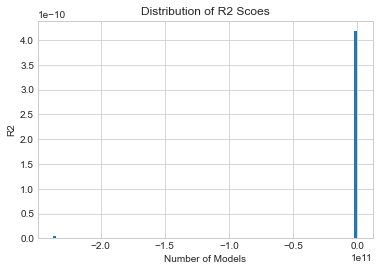

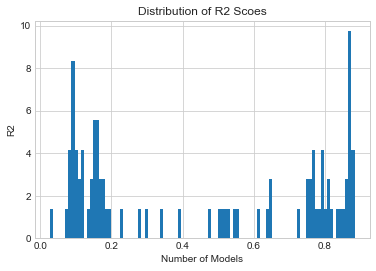

In [10]:
from matplotlib import pyplot as plt
if True:
    # plot deep results as a function of number of features

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores["R2"][name],n_features_dict[name]] for name in scores["R2"].keys()]
                           ,columns = ["name","score","n_features"])

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores["R2"][name],n_features_dict[name]] for name in scores["R2"].keys()]
                           ,columns = ["name","score","n_features"])
    to_plot = to_plot[to_plot["score"]>=0]

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot_compressed.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')
    pass

    #plot


In [11]:
n_features_dict

{'random_0': 43,
 'random_1': 26,
 'random_2': 21,
 'random_3': 12,
 'random_4': 27,
 'random_5': 46,
 'random_6': 30,
 'random_7': 11,
 'random_8': 14,
 'random_9': 48,
 'random_10': 9,
 'random_11': 49,
 'random_12': 8,
 'random_13': 9,
 'random_14': 3,
 'random_15': 29,
 'random_16': 6,
 'random_17': 33,
 'random_18': 36,
 'random_19': 30,
 'random_20': 6,
 'random_21': 3,
 'random_22': 7,
 'random_23': 20,
 'random_24': 2,
 'random_25': 34,
 'random_26': 44,
 'random_27': 27,
 'random_28': 2,
 'random_29': 37,
 'random_30': 17,
 'random_31': 45,
 'random_32': 30,
 'random_33': 44,
 'random_34': 44,
 'random_35': 6,
 'random_36': 34,
 'random_37': 34,
 'random_38': 23,
 'random_39': 33,
 'random_40': 36,
 'random_41': 25,
 'random_42': 2,
 'random_43': 50,
 'random_44': 44,
 'random_45': 14,
 'random_46': 22,
 'random_47': 49,
 'random_48': 44,
 'random_49': 3,
 'random_50': 9,
 'random_51': 42,
 'random_52': 34,
 'random_53': 18,
 'random_54': 21,
 'random_55': 19,
 'random_56': 11

In [12]:
summary_logger.info("------------------\n Top 5 performance on Test Set")
summary_logger.info(f"Index - Model - Val MSE - Val R2 - Test MSE - Test R2")
for i,key in enumerate(sorted(scores['MSE'],key=scores['MSE'].get)):
    if i <5:
        summary_logger.info(f"{i} - {key} - {scores['MSE'][key]} - {scores['R2'][key]} - {scores_final['MSE'][key]} - {scores_final['R2'][key]}")

------------------
 Top 5 performance on Test Set'
Index - Model - Val MSE - Val R2 - Test MSE - Test R2'
0 - random_5 - 0.7013715591267368 - 0.8837900159769211 - 0.6819591550745818 - 0.8867007703494437'
1 - random_77 - 0.7117421569982778 - 0.8820717156020641 - 0.6978397524084563 - 0.8840624020088619'
2 - random_40 - 0.713709026582627 - 0.8817458257367018 - 0.6879597375550135 - 0.8857038464612188'
3 - random_36 - 0.7557703164162529 - 0.8747767067926123 - 0.738428378560086 - 0.8773190948161442'
4 - random_57 - 0.757060424220161 - 0.8745629493265028 - 0.7547794757714478 - 0.8746025586362229'


In [13]:
model_path = Path('D:/workspace/lazydeep/experiments/2.00')
log_path = Path("D:/workspace/lazydeep/experiments/2.01")

log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

if not log_dir.exists():
    log_dir.mkdir()
    
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary2",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary2")
tb = SummaryWriter(log_dir/"tb")

    
    
deep_scores_dict={}
deep_preds_dict={}
actual_y = None
preprocessing=StandardScaler()

load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))

deep_scheme = DeepScheme(configs, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=False,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval.evaluate(models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp=load_fun_pp_cv)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval.build(models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Tested (test) on 1905 instances with mean losses of: random_0:4.6972,random_1:4.9882,random_2:5.294,random_3:4.0932,random_4:5.7782,random_5:0.6968,random_6:274.54,random_7:4.8655,random_8:4.8197,random_9:1.1964,random_10:12.7892,random_11:2.9559,random_12:1.0481,random_13:2.3262,random_14:6.2745,random_15:4.5511,random_16:0.7896,random_17:3.5054,random_18:1.1522,random_19:3.9419,random_20:4.8054,random_21:5.5192,random_22:2.7355,random_23:1.655,random_24:6.0636,random_25:4.7686,random_26:0.8162,random_27:4.7895,random_28:4.847,random_29:6.0638,random_30:1.2468,random_31:1.1502,random_32:5.8631,random_33:267.8796,random_34:1.4431,random_35:3.2188,random_36:0.7397,random_37:4.7581,random_38:4.6451,random_39:4.4726,random_40:0.7285,random_41:4.9642,random_42:0.8076,random_43:8.7956,random_44:4.6952,random_45:10.7266,random_46:5.2951,rand

In [14]:
all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})
    
all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})  

scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_5 - deep - 0.6968225541703031 - 0.7278882824398978 - 0.7268095401740283 - 0.6778591419956443 - 0.6776655337231482 - 0.7013715591267368 - 0.8837900159769211
1 - random_77 - deep - 0.7272528599879248 - 0.7336461647544675 - 0.7002115975228793 - 0.7170626751557854 - 0.6802849616559602 - 0.7117421569982778 - 0.8820717156020641
2 - random_40 - deep - 0.7285027828116429 - 0.7219616424549571 - 0.7262313921671893 - 0.683305238946231 - 0.7095062936224589 - 0.713709026582627 - 0.8817458257367018
3 - random_36 - deep - 0.7397091557034671 - 0.8029673554479618 - 0.7368969113080848 - 0.7741180350577909 - 0.7237985857453566 - 0.7557703164162529 - 0.8747767067926123
4 - random_57 - deep - 0.7901938553557308 - 0.8219972984717631 - 0.733523698276506 - 0.7132647038105446 - 0.7272885274287018 - 0.757060424220161 - 0.8745629493265028
5 - random_42 - deep - 0.8076145739380143 - 0.7557362568347961 - 0.7669930294363783 - 0.7342574616483014 - 0.7346215185162683 - 0.7595685607046051 - 0.87414737715652

In [19]:
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression
from plot import plot_preds_and_res

for deep_name,deep_model in models.items():
    if not deep_name in ['random_39','random_40']:
        print(deep_name)
        logging.getLogger().info(f"Running model {deep_name}")
        temp_dict = {deep_name:deep_model}

        lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_exh(nrow),n_neighbours=500,loss_fun_sk = mean_squared_error)
        lwr_scores, lwr_preds, _ , _, _,_= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
        lwr_scores_final, lwr_preds_final, _ , _, _,_= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

        #scores
        for k,v in ut.flip_dicts(lwr_scores).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores.append({**dict1,**v})

        for k,v in ut.flip_dicts(lwr_scores_final).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores_final.append({**dict1,**v})

        lwr_preds['deep'] = deep_preds[deep_name]
        lwr_preds_final['deep'] = deep_preds_final[deep_name]

        lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
        lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

        #preds
        # todo save predictions - appending solns
        plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)



random_0
Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.1421,lwr_k=10:0.0013,lwr_k=20:0.0431,lwr_k=30:0.3816,lwr_k=40:0.4901,lwr_k=50:2.934,lwr_k=100:4.6208,lwr_k=200:15.7632,lwr_k=300:23.9869,lwr_k=400:30.8396,lwr_k=500:27.119,lwr_k=600:31.576,lwr_k=700:26.6872,lwr_k=800:31.5495,lwr_k=900:27.3719,lwr_k=1000:27.1624'
Tested (test) on 1905 instances with mean losses of: lr:4.2201,lwr_k=10:2358.7227,lwr_k=20:22147568.097,lwr_k=30:11538633.2841,lwr_k=40:39831048.7667,lwr_k=50:23762570.5457,lwr_k=100:53139448.1886,lwr_k=200:44224590.6522,lwr_k=300:129.8525,lwr_k=400:15914.4352,lwr_k=500:41.9195,lwr_k=600:48.7915,lwr_k=700:479.4011,lwr_k=800:384.9622,lwr_k=900:322.2865,lwr_k=1000:169.7387'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished t

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_1
Running model random_1'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5811,lwr_k=10:0.0001,lwr_k=20:0.0138,lwr_k=30:0.5599,lwr_k=40:1.2748,lwr_k=50:1.8527,lwr_k=100:2.9962,lwr_k=200:4.0296,lwr_k=300:4.0959,lwr_k=400:4.3557,lwr_k=500:4.3964,lwr_k=600:4.4158,lwr_k=700:4.402,lwr_k=800:4.3963,lwr_k=900:4.3685,lwr_k=1000:4.3345'
Tested (test) on 1905 instances with mean losses of: lr:4.5009,lwr_k=10:38.7078,lwr_k=20:148.3316,lwr_k=30:113.5415,lwr_k=40:92.2834,lwr_k=50:65.9753,lwr_k=100:6.6233,lwr_k=200:5.1095,lwr_k=300:4.9858,lwr_k=400:4.7516,lwr_k=500:4.8471,lwr_k=600:4.6295,lwr_k=700:4.7907,lwr_k=800:4.5927,lwr_k=900:4.569,lwr_k=1000:4.4837'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6219,lwr_k=10:0.000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_2
Running model random_2'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.7518,lwr_k=10:0.0001,lwr_k=20:0.2038,lwr_k=30:0.3147,lwr_k=40:0.4705,lwr_k=50:0.5835,lwr_k=100:0.9094,lwr_k=200:1.2126,lwr_k=300:1.474,lwr_k=400:1.6725,lwr_k=500:1.8731,lwr_k=600:2.0628,lwr_k=700:2.2608,lwr_k=800:2.4676,lwr_k=900:2.7161,lwr_k=1000:2.9516'
Tested (test) on 1905 instances with mean losses of: lr:4.6558,lwr_k=10:701.6757,lwr_k=20:133087.0165,lwr_k=30:110326.4997,lwr_k=40:107967.2445,lwr_k=50:144436.7574,lwr_k=100:194219.4037,lwr_k=200:52718.5001,lwr_k=300:16737.7281,lwr_k=400:256075.5663,lwr_k=500:109954.5887,lwr_k=600:222832.0496,lwr_k=700:173961.1865,lwr_k=800:1053.8583,lwr_k=900:27795.6672,lwr_k=1000:37787.8626'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished tr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_3
Running model random_3'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.2371,lwr_k=10:0.1105,lwr_k=20:0.3434,lwr_k=30:0.4599,lwr_k=40:0.5339,lwr_k=50:0.5851,lwr_k=100:0.697,lwr_k=200:0.7765,lwr_k=300:0.819,lwr_k=400:0.8537,lwr_k=500:0.8773,lwr_k=600:0.8988,lwr_k=700:0.9175,lwr_k=800:0.9292,lwr_k=900:0.9426,lwr_k=1000:0.9554'
Tested (test) on 1905 instances with mean losses of: lr:1.2344,lwr_k=10:1974716.5735,lwr_k=20:21567050.0559,lwr_k=30:12173803.1979,lwr_k=40:54959607.4336,lwr_k=50:19.4518,lwr_k=100:0.8355,lwr_k=200:0.848,lwr_k=300:0.8798,lwr_k=400:0.9115,lwr_k=500:0.9326,lwr_k=600:0.9575,lwr_k=700:0.977,lwr_k=800:0.9865,lwr_k=900:0.9981,lwr_k=1000:1.0096'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_4
Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.3493,lwr_k=10:0.0,lwr_k=20:0.0065,lwr_k=30:0.2599,lwr_k=40:0.2617,lwr_k=50:0.3555,lwr_k=100:0.5751,lwr_k=200:0.7511,lwr_k=300:0.8049,lwr_k=400:0.8734,lwr_k=500:0.9309,lwr_k=600:0.9127,lwr_k=700:0.9531,lwr_k=800:0.9525,lwr_k=900:0.9794,lwr_k=1000:1.027'
Tested (test) on 1905 instances with mean losses of: lr:1.8502,lwr_k=10:18.7989,lwr_k=20:57.5832,lwr_k=30:29.0978,lwr_k=40:5.6004,lwr_k=50:3.0604,lwr_k=100:2.066,lwr_k=200:1.0547,lwr_k=300:1.1009,lwr_k=400:1.1688,lwr_k=500:1.1854,lwr_k=600:1.0697,lwr_k=700:1.1576,lwr_k=800:1.0995,lwr_k=900:1.1614,lwr_k=1000:1.0964'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6269,lwr_k=10:0.0,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_5
Running model random_5'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6214,lwr_k=10:0.0,lwr_k=20:0.015,lwr_k=30:0.121,lwr_k=40:0.213,lwr_k=50:0.309,lwr_k=100:0.4299,lwr_k=200:0.5148,lwr_k=300:0.5463,lwr_k=400:0.5616,lwr_k=500:0.5759,lwr_k=600:0.5817,lwr_k=700:0.5911,lwr_k=800:0.597,lwr_k=900:0.6009,lwr_k=1000:0.604'
Tested (test) on 1905 instances with mean losses of: lr:0.6636,lwr_k=10:9.7716,lwr_k=20:156.2551,lwr_k=30:40.2075,lwr_k=40:21.249,lwr_k=50:1.9064,lwr_k=100:0.7211,lwr_k=200:0.6699,lwr_k=300:0.6604,lwr_k=400:0.6506,lwr_k=500:0.6517,lwr_k=600:0.6517,lwr_k=700:0.6513,lwr_k=800:0.6492,lwr_k=900:0.6523,lwr_k=1000:0.6519'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.647,lwr_k=10:0.0,lwr_k=20:0.00

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_6
Running model random_6'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.3674,lwr_k=10:0.0,lwr_k=20:0.0236,lwr_k=30:1.2648,lwr_k=40:0.9869,lwr_k=50:0.9421,lwr_k=100:0.7705,lwr_k=200:0.8969,lwr_k=300:0.9817,lwr_k=400:1.0005,lwr_k=500:1.1014,lwr_k=600:1.3104,lwr_k=700:1.654,lwr_k=800:1.9913,lwr_k=900:2.2416,lwr_k=1000:2.7526'
Tested (test) on 1905 instances with mean losses of: lr:5.3836,lwr_k=10:13.3254,lwr_k=20:21.4744,lwr_k=30:6.1888,lwr_k=40:3.3407,lwr_k=50:2.1506,lwr_k=100:1.4059,lwr_k=200:1.0833,lwr_k=300:1.1381,lwr_k=400:1.1192,lwr_k=500:1.2029,lwr_k=600:1.4887,lwr_k=700:1.7887,lwr_k=800:2.2212,lwr_k=900:2.2788,lwr_k=1000:2.8945'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.5541,lwr_k=10:0.0,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_7
Running model random_7'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.7899,lwr_k=10:4.79,lwr_k=20:1.9202,lwr_k=30:2.2795,lwr_k=40:2.5714,lwr_k=50:2.775,lwr_k=100:3.2726,lwr_k=200:3.631,lwr_k=300:3.7893,lwr_k=400:3.9709,lwr_k=500:4.0432,lwr_k=600:4.1227,lwr_k=700:4.2184,lwr_k=800:4.2682,lwr_k=900:4.3482,lwr_k=1000:4.3931'
Tested (test) on 1905 instances with mean losses of: lr:4.6794,lwr_k=10:51458.5218,lwr_k=20:18807.0613,lwr_k=30:5976.0736,lwr_k=40:9.7647,lwr_k=50:15.2552,lwr_k=100:7.8704,lwr_k=200:5.9612,lwr_k=300:3.8641,lwr_k=400:5.3538,lwr_k=500:4.3725,lwr_k=600:4.1861,lwr_k=700:4.2264,lwr_k=800:4.357,lwr_k=900:4.4731,lwr_k=1000:4.5478'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.252,lwr_k=10:7.50

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_8
Running model random_8'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8813,lwr_k=10:2.1379,lwr_k=20:3.4044,lwr_k=30:2.9466,lwr_k=40:3.1829,lwr_k=50:3.3301,lwr_k=100:3.9192,lwr_k=200:4.1704,lwr_k=300:4.3284,lwr_k=400:4.3657,lwr_k=500:4.4411,lwr_k=600:4.4857,lwr_k=700:4.5192,lwr_k=800:4.5429,lwr_k=900:4.5477,lwr_k=1000:4.5705'
Tested (test) on 1905 instances with mean losses of: lr:4.7934,lwr_k=10:37005.9691,lwr_k=20:552682.1306,lwr_k=30:21982.2324,lwr_k=40:50893.6018,lwr_k=50:320.9131,lwr_k=100:4224.8442,lwr_k=200:4.5822,lwr_k=300:4.5896,lwr_k=400:4.581,lwr_k=500:4.6168,lwr_k=600:4.6095,lwr_k=700:4.6138,lwr_k=800:4.6139,lwr_k=900:4.6049,lwr_k=1000:4.604'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.5891

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_9
Running model random_9'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9643,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0003,lwr_k=40:0.0197,lwr_k=50:0.0357,lwr_k=100:0.2305,lwr_k=200:0.4447,lwr_k=300:0.568,lwr_k=400:0.6277,lwr_k=500:0.6626,lwr_k=600:0.6873,lwr_k=700:0.7079,lwr_k=800:0.725,lwr_k=900:0.7416,lwr_k=1000:0.7557'
Tested (test) on 1905 instances with mean losses of: lr:0.9761,lwr_k=10:1.0638,lwr_k=20:1.7925,lwr_k=30:19.2614,lwr_k=40:614.8279,lwr_k=50:5.2456,lwr_k=100:1.2188,lwr_k=200:0.7821,lwr_k=300:0.7569,lwr_k=400:0.7794,lwr_k=500:0.7882,lwr_k=600:0.7955,lwr_k=700:0.8018,lwr_k=800:0.802,lwr_k=900:0.8144,lwr_k=1000:0.8235'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9266,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_10
Running model random_10'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8881,lwr_k=10:0.0005,lwr_k=20:0.9453,lwr_k=30:1.5967,lwr_k=40:1.9897,lwr_k=50:2.2339,lwr_k=100:2.8572,lwr_k=200:3.3588,lwr_k=300:3.6193,lwr_k=400:3.8275,lwr_k=500:3.9564,lwr_k=600:4.058,lwr_k=700:4.1608,lwr_k=800:4.2324,lwr_k=900:4.2961,lwr_k=1000:4.3766'
Tested (test) on 1905 instances with mean losses of: lr:4.7332,lwr_k=10:29964.8756,lwr_k=20:9.4718,lwr_k=30:3.329,lwr_k=40:3.2774,lwr_k=50:3.4139,lwr_k=100:3.2626,lwr_k=200:3.4695,lwr_k=300:3.6822,lwr_k=400:3.8296,lwr_k=500:3.919,lwr_k=600:4.0216,lwr_k=700:4.1212,lwr_k=800:4.1841,lwr_k=900:4.2462,lwr_k=1000:4.3153'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.8312,lwr_k=10:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_11
Running model random_11'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.1527,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0008,lwr_k=40:0.0146,lwr_k=50:0.1589,lwr_k=100:0.4724,lwr_k=200:0.5714,lwr_k=300:0.67,lwr_k=400:0.6978,lwr_k=500:0.7206,lwr_k=600:0.7413,lwr_k=700:0.7537,lwr_k=800:0.7698,lwr_k=900:0.7909,lwr_k=1000:0.8082'
Tested (test) on 1905 instances with mean losses of: lr:1.2292,lwr_k=10:1.4233,lwr_k=20:3.4429,lwr_k=30:172.1659,lwr_k=40:478.1767,lwr_k=50:39646.773,lwr_k=100:109.0748,lwr_k=200:1.2319,lwr_k=300:0.8747,lwr_k=400:0.8464,lwr_k=500:0.8525,lwr_k=600:0.8538,lwr_k=700:0.8606,lwr_k=800:0.8671,lwr_k=900:0.881,lwr_k=1000:0.8896'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.4946,lwr_k=10:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_12
Running model random_12'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9045,lwr_k=10:0.8229,lwr_k=20:0.8515,lwr_k=30:0.8603,lwr_k=40:0.8657,lwr_k=50:0.8694,lwr_k=100:0.8751,lwr_k=200:0.8788,lwr_k=300:0.8813,lwr_k=400:0.8843,lwr_k=500:0.8852,lwr_k=600:0.8876,lwr_k=700:0.8895,lwr_k=800:0.8908,lwr_k=900:0.8927,lwr_k=1000:0.8941'
Tested (test) on 1905 instances with mean losses of: lr:0.9195,lwr_k=10:1.0035,lwr_k=20:0.9376,lwr_k=30:0.9272,lwr_k=40:0.9155,lwr_k=50:0.9155,lwr_k=100:0.9062,lwr_k=200:0.9031,lwr_k=300:0.9009,lwr_k=400:0.9012,lwr_k=500:0.9015,lwr_k=600:0.9017,lwr_k=700:0.9029,lwr_k=800:0.905,lwr_k=900:0.9063,lwr_k=1000:0.9064'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9493,lwr_k=10:0.9385,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_13
Running model random_13'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0718,lwr_k=10:0.0001,lwr_k=20:0.2691,lwr_k=30:0.4146,lwr_k=40:0.4969,lwr_k=50:0.5535,lwr_k=100:0.6709,lwr_k=200:0.7479,lwr_k=300:0.7828,lwr_k=400:0.8072,lwr_k=500:0.8302,lwr_k=600:0.8479,lwr_k=700:0.8601,lwr_k=800:0.8704,lwr_k=900:0.8788,lwr_k=1000:0.8866'
Tested (test) on 1905 instances with mean losses of: lr:1.0397,lwr_k=10:536.4551,lwr_k=20:1.1119,lwr_k=30:0.8604,lwr_k=40:0.7966,lwr_k=50:0.7686,lwr_k=100:0.7717,lwr_k=200:0.8024,lwr_k=300:0.8209,lwr_k=400:0.8359,lwr_k=500:0.8445,lwr_k=600:0.8573,lwr_k=700:0.8638,lwr_k=800:0.8668,lwr_k=900:0.8715,lwr_k=1000:0.8784'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.1245,lwr_k=10:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_14
Running model random_14'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0954,lwr_k=10:6.4469,lwr_k=20:6.3282,lwr_k=30:6.7596,lwr_k=40:6.5083,lwr_k=50:6.3271,lwr_k=100:6.1126,lwr_k=200:6.1186,lwr_k=300:6.1607,lwr_k=400:6.1256,lwr_k=500:6.1247,lwr_k=600:6.1044,lwr_k=700:6.0997,lwr_k=800:6.1041,lwr_k=900:6.0985,lwr_k=1000:6.1005'
Tested (test) on 1905 instances with mean losses of: lr:6.0726,lwr_k=10:6.2964,lwr_k=20:6.2015,lwr_k=30:6.5612,lwr_k=40:6.3471,lwr_k=50:6.2006,lwr_k=100:6.118,lwr_k=200:6.1286,lwr_k=300:6.193,lwr_k=400:6.1402,lwr_k=500:6.1388,lwr_k=600:6.1019,lwr_k=700:6.0912,lwr_k=800:6.1015,lwr_k=900:6.0877,lwr_k=1000:6.0931'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.1332,lwr_k=10:6.1731,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_15
Running model random_15'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.109,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0102,lwr_k=40:0.1127,lwr_k=50:0.1968,lwr_k=100:0.4236,lwr_k=200:0.5959,lwr_k=300:0.6748,lwr_k=400:0.7388,lwr_k=500:0.8046,lwr_k=600:0.8777,lwr_k=700:0.9504,lwr_k=800:1.0083,lwr_k=900:1.0653,lwr_k=1000:1.1246'
Tested (test) on 1905 instances with mean losses of: lr:2.9148,lwr_k=10:10.6026,lwr_k=20:4.6152,lwr_k=30:78.6304,lwr_k=40:2.1599,lwr_k=50:1.2972,lwr_k=100:0.8608,lwr_k=200:0.8072,lwr_k=300:0.8405,lwr_k=400:0.8744,lwr_k=500:0.9365,lwr_k=600:0.9876,lwr_k=700:1.0181,lwr_k=800:1.0875,lwr_k=900:1.1349,lwr_k=1000:1.1785'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9269,lwr_k=10:0.0,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_16
Running model random_16'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7042,lwr_k=10:0.621,lwr_k=20:0.6631,lwr_k=30:0.6755,lwr_k=40:0.6825,lwr_k=50:0.6853,lwr_k=100:0.6915,lwr_k=200:0.6927,lwr_k=300:0.6937,lwr_k=400:0.6949,lwr_k=500:0.696,lwr_k=600:0.6965,lwr_k=700:0.6968,lwr_k=800:0.6967,lwr_k=900:0.697,lwr_k=1000:0.697'
Tested (test) on 1905 instances with mean losses of: lr:0.7574,lwr_k=10:0.8242,lwr_k=20:0.7797,lwr_k=30:0.7676,lwr_k=40:0.7608,lwr_k=50:0.7568,lwr_k=100:0.7495,lwr_k=200:0.7472,lwr_k=300:0.7463,lwr_k=400:0.7454,lwr_k=500:0.7463,lwr_k=600:0.7473,lwr_k=700:0.7481,lwr_k=800:0.7485,lwr_k=900:0.7485,lwr_k=1000:0.7492'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7969,lwr_k=10:0.6851,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_17
Running model random_17'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0963,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0003,lwr_k=40:0.0384,lwr_k=50:0.1244,lwr_k=100:0.3819,lwr_k=200:0.5589,lwr_k=300:0.6365,lwr_k=400:0.6857,lwr_k=500:0.7101,lwr_k=600:0.7328,lwr_k=700:0.7486,lwr_k=800:0.762,lwr_k=900:0.7765,lwr_k=1000:0.7891'
Tested (test) on 1905 instances with mean losses of: lr:1.0941,lwr_k=10:1.8891,lwr_k=20:6.0409,lwr_k=30:440.48,lwr_k=40:77.3189,lwr_k=50:5.2804,lwr_k=100:0.9492,lwr_k=200:0.7526,lwr_k=300:0.782,lwr_k=400:0.7981,lwr_k=500:0.8084,lwr_k=600:0.8252,lwr_k=700:0.8331,lwr_k=800:0.8399,lwr_k=900:0.8518,lwr_k=1000:0.862'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7292,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_18
Running model random_18'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0007,lwr_k=10:0.0,lwr_k=20:0.0016,lwr_k=30:0.2996,lwr_k=40:1.7364,lwr_k=50:1.8485,lwr_k=100:1.0818,lwr_k=200:0.7732,lwr_k=300:0.7466,lwr_k=400:0.7716,lwr_k=500:0.7478,lwr_k=600:0.7603,lwr_k=700:0.7676,lwr_k=800:0.7685,lwr_k=900:0.7775,lwr_k=1000:0.787'
Tested (test) on 1905 instances with mean losses of: lr:9984.8497,lwr_k=10:7.789,lwr_k=20:1608.119,lwr_k=30:205536.7199,lwr_k=40:60404.7027,lwr_k=50:45427.114,lwr_k=100:374.1431,lwr_k=200:2058.8071,lwr_k=300:746.7011,lwr_k=400:407.7868,lwr_k=500:475.7477,lwr_k=600:31680.3991,lwr_k=700:9326.4847,lwr_k=800:9705.7904,lwr_k=900:17920.8068,lwr_k=1000:41616.403'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a t

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_19
Running model random_19'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.0701,lwr_k=10:3.7364,lwr_k=20:3.9065,lwr_k=30:3.9401,lwr_k=40:3.9552,lwr_k=50:3.9702,lwr_k=100:3.9876,lwr_k=200:4.0047,lwr_k=300:4.008,lwr_k=400:4.0096,lwr_k=500:4.0171,lwr_k=600:4.0227,lwr_k=700:4.0214,lwr_k=800:4.0233,lwr_k=900:4.0223,lwr_k=1000:4.0229'
Tested (test) on 1905 instances with mean losses of: lr:3.8906,lwr_k=10:4.1803,lwr_k=20:4.0172,lwr_k=30:3.9375,lwr_k=40:3.8867,lwr_k=50:3.88,lwr_k=100:3.8757,lwr_k=200:3.8842,lwr_k=300:3.8778,lwr_k=400:3.8689,lwr_k=500:3.8622,lwr_k=600:3.8674,lwr_k=700:3.8577,lwr_k=800:3.8548,lwr_k=900:3.8586,lwr_k=1000:3.8609'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8921,lwr_k=10:4.1802,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_20
Running model random_20'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5781,lwr_k=10:0.5364,lwr_k=20:1.6508,lwr_k=30:2.0727,lwr_k=40:2.3298,lwr_k=50:2.4798,lwr_k=100:2.8792,lwr_k=200:3.2875,lwr_k=300:3.4416,lwr_k=400:3.5376,lwr_k=500:3.5958,lwr_k=600:3.6377,lwr_k=700:3.6744,lwr_k=800:3.6985,lwr_k=900:3.7217,lwr_k=1000:3.7467'
Tested (test) on 1905 instances with mean losses of: lr:4.4856,lwr_k=10:10.6227,lwr_k=20:3.4923,lwr_k=30:3.1246,lwr_k=40:3.0103,lwr_k=50:3.0687,lwr_k=100:3.1361,lwr_k=200:3.3415,lwr_k=300:3.3619,lwr_k=400:3.4491,lwr_k=500:3.4994,lwr_k=600:3.5339,lwr_k=700:3.5577,lwr_k=800:3.5732,lwr_k=900:3.6002,lwr_k=1000:3.629'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.7175,lwr_k=10:0.5408,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_21
Running model random_21'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.5711,lwr_k=10:5.3778,lwr_k=20:5.4451,lwr_k=30:5.4286,lwr_k=40:5.427,lwr_k=50:5.4195,lwr_k=100:5.4432,lwr_k=200:5.4704,lwr_k=300:5.4887,lwr_k=400:5.5051,lwr_k=500:5.5181,lwr_k=600:5.5138,lwr_k=700:5.5293,lwr_k=800:5.5358,lwr_k=900:5.5389,lwr_k=1000:5.5402'
Tested (test) on 1905 instances with mean losses of: lr:5.4199,lwr_k=10:7.0243,lwr_k=20:5.9803,lwr_k=30:5.7631,lwr_k=40:5.673,lwr_k=50:5.5475,lwr_k=100:5.4154,lwr_k=200:5.4309,lwr_k=300:5.394,lwr_k=400:5.3831,lwr_k=500:5.3883,lwr_k=600:5.3826,lwr_k=700:5.3857,lwr_k=800:5.3969,lwr_k=900:5.3968,lwr_k=1000:5.4022'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.658,lwr_k=10:4.782,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_22
Running model random_22'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.3094,lwr_k=10:0.2594,lwr_k=20:0.8182,lwr_k=30:1.0346,lwr_k=40:1.1486,lwr_k=50:1.2241,lwr_k=100:1.3991,lwr_k=200:1.5373,lwr_k=300:1.617,lwr_k=400:1.6757,lwr_k=500:1.724,lwr_k=600:1.7788,lwr_k=700:1.8209,lwr_k=800:1.8529,lwr_k=900:1.8805,lwr_k=1000:1.9063'
Tested (test) on 1905 instances with mean losses of: lr:2.2832,lwr_k=10:5.3381,lwr_k=20:1.6215,lwr_k=30:1.5169,lwr_k=40:1.5513,lwr_k=50:1.5815,lwr_k=100:1.5783,lwr_k=200:1.6308,lwr_k=300:1.6742,lwr_k=400:1.7141,lwr_k=500:1.7465,lwr_k=600:1.788,lwr_k=700:1.823,lwr_k=800:1.8559,lwr_k=900:1.8835,lwr_k=1000:1.9071'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.0803,lwr_k=10:0.1989,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_23
Running model random_23'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7327,lwr_k=10:0.0,lwr_k=20:0.0013,lwr_k=30:0.1316,lwr_k=40:0.2583,lwr_k=50:0.3369,lwr_k=100:0.5021,lwr_k=200:0.5848,lwr_k=300:0.6177,lwr_k=400:0.6346,lwr_k=500:0.6437,lwr_k=600:0.6501,lwr_k=700:0.6552,lwr_k=800:0.6585,lwr_k=900:0.6623,lwr_k=1000:0.6671'
Tested (test) on 1905 instances with mean losses of: lr:0.7658,lwr_k=10:25.4061,lwr_k=20:788.7211,lwr_k=30:137.4683,lwr_k=40:1.5461,lwr_k=50:0.9331,lwr_k=100:0.6921,lwr_k=200:0.6881,lwr_k=300:0.7005,lwr_k=400:0.7131,lwr_k=500:0.7171,lwr_k=600:0.7184,lwr_k=700:0.7182,lwr_k=800:0.7165,lwr_k=900:0.7193,lwr_k=1000:0.7214'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6857,lwr_k=10:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_24
Running model random_24'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.7683,lwr_k=10:6.7819,lwr_k=20:6.3995,lwr_k=30:5.9647,lwr_k=40:5.9106,lwr_k=50:5.9832,lwr_k=100:5.6872,lwr_k=200:5.7099,lwr_k=300:5.6575,lwr_k=400:5.6532,lwr_k=500:5.7223,lwr_k=600:5.6749,lwr_k=700:5.665,lwr_k=800:5.6575,lwr_k=900:5.6475,lwr_k=1000:5.6432'
Tested (test) on 1905 instances with mean losses of: lr:5.7452,lwr_k=10:6.766,lwr_k=20:6.4668,lwr_k=30:6.0134,lwr_k=40:5.9787,lwr_k=50:6.1658,lwr_k=100:5.6769,lwr_k=200:5.695,lwr_k=300:5.6644,lwr_k=400:5.634,lwr_k=500:5.7201,lwr_k=600:5.6561,lwr_k=700:5.648,lwr_k=800:5.6293,lwr_k=900:5.6228,lwr_k=1000:5.6208'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0767,lwr_k=10:6.273,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_25
Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.7194,lwr_k=10:3.9278,lwr_k=20:3.381,lwr_k=30:3.6342,lwr_k=40:3.8035,lwr_k=50:3.8935,lwr_k=100:4.1696,lwr_k=200:4.3843,lwr_k=300:4.4444,lwr_k=400:4.4936,lwr_k=500:4.5299,lwr_k=600:4.5394,lwr_k=700:4.5549,lwr_k=800:4.5692,lwr_k=900:4.5891,lwr_k=1000:4.6066'
Tested (test) on 1905 instances with mean losses of: lr:4.6547,lwr_k=10:3889088.955,lwr_k=20:162194.8314,lwr_k=30:12334.4885,lwr_k=40:6.1317,lwr_k=50:5.144,lwr_k=100:4.7945,lwr_k=200:4.6049,lwr_k=300:4.608,lwr_k=400:4.6202,lwr_k=500:4.6184,lwr_k=600:4.6105,lwr_k=700:4.6242,lwr_k=800:4.6349,lwr_k=900:4.6466,lwr_k=1000:4.6546'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6743,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_26
Running model random_26'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.666,lwr_k=10:0.5844,lwr_k=20:0.6262,lwr_k=30:0.6412,lwr_k=40:0.6491,lwr_k=50:0.6527,lwr_k=100:0.6597,lwr_k=200:0.6626,lwr_k=300:0.663,lwr_k=400:0.6628,lwr_k=500:0.6635,lwr_k=600:0.6644,lwr_k=700:0.6641,lwr_k=800:0.6639,lwr_k=900:0.6641,lwr_k=1000:0.6642'
Tested (test) on 1905 instances with mean losses of: lr:0.7965,lwr_k=10:0.8141,lwr_k=20:0.7616,lwr_k=30:0.7541,lwr_k=40:0.75,lwr_k=50:0.7474,lwr_k=100:0.7358,lwr_k=200:0.738,lwr_k=300:0.7378,lwr_k=400:0.7371,lwr_k=500:0.7542,lwr_k=600:0.7353,lwr_k=700:0.7389,lwr_k=800:0.7404,lwr_k=900:0.7385,lwr_k=1000:0.7385'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7194,lwr_k=10:0.4128,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_27
Running model random_27'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6424,lwr_k=10:0.0174,lwr_k=20:0.8053,lwr_k=30:1.4132,lwr_k=40:1.9676,lwr_k=50:2.3595,lwr_k=100:3.2342,lwr_k=200:3.7958,lwr_k=300:3.9888,lwr_k=400:4.1093,lwr_k=500:4.1749,lwr_k=600:4.2297,lwr_k=700:4.2557,lwr_k=800:4.2852,lwr_k=900:4.2976,lwr_k=1000:4.3209'
Tested (test) on 1905 instances with mean losses of: lr:4.5543,lwr_k=10:152.6561,lwr_k=20:606.9285,lwr_k=30:166.4627,lwr_k=40:488.6496,lwr_k=50:12.4495,lwr_k=100:10.186,lwr_k=200:5.8614,lwr_k=300:5.5948,lwr_k=400:4.6775,lwr_k=500:4.7018,lwr_k=600:4.357,lwr_k=700:4.3319,lwr_k=800:4.3331,lwr_k=900:4.3496,lwr_k=1000:4.3436'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5087,lwr_k=10:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_28
Running model random_28'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.795,lwr_k=10:3.4533,lwr_k=20:3.9948,lwr_k=30:4.1656,lwr_k=40:4.2575,lwr_k=50:4.3285,lwr_k=100:4.453,lwr_k=200:4.5464,lwr_k=300:4.5989,lwr_k=400:4.62,lwr_k=500:4.6475,lwr_k=600:4.6554,lwr_k=700:4.6609,lwr_k=800:4.6686,lwr_k=900:4.6752,lwr_k=1000:4.6816'
Tested (test) on 1905 instances with mean losses of: lr:4.6701,lwr_k=10:5.2151,lwr_k=20:4.8861,lwr_k=30:4.6507,lwr_k=40:4.5521,lwr_k=50:4.5159,lwr_k=100:4.4734,lwr_k=200:4.4992,lwr_k=300:4.4977,lwr_k=400:4.5138,lwr_k=500:4.5314,lwr_k=600:4.5435,lwr_k=700:4.5517,lwr_k=800:4.548,lwr_k=900:4.5518,lwr_k=1000:4.5526'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1003,lwr_k=10:3.6122,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_29
Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.201,lwr_k=10:6.4469,lwr_k=20:6.3282,lwr_k=30:6.7596,lwr_k=40:272.5986,lwr_k=50:272.5986,lwr_k=100:67376604.1994,lwr_k=200:245699.8736,lwr_k=300:272.5986,lwr_k=400:66841668.9978,lwr_k=500:4127709.6984,lwr_k=600:272.5986,lwr_k=700:66841668.9978,lwr_k=800:1082282.0487,lwr_k=900:272.5986,lwr_k=1000:1082282.0487'
Tested (test) on 1905 instances with mean losses of: lr:6.112,lwr_k=10:6.2964,lwr_k=20:6.2015,lwr_k=30:6.5612,lwr_k=40:4617301808.7122,lwr_k=50:5843940174.0715,lwr_k=100:126549238.5218,lwr_k=200:3224073.9383,lwr_k=300:1760286.9264,lwr_k=400:72482609.2802,lwr_k=500:11888654.9636,lwr_k=600:34094704.7722,lwr_k=700:67406526.1262,lwr_k=800:1477685.3136,lwr_k=900:338008.8542,lwr_k=1000:1094528.3028'
-----------------------------------Fold 1 - Train 585

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_30
Running model random_30'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8735,lwr_k=10:0.6926,lwr_k=20:0.7626,lwr_k=30:0.7957,lwr_k=40:0.8073,lwr_k=50:0.8146,lwr_k=100:0.8256,lwr_k=200:0.8362,lwr_k=300:0.8402,lwr_k=400:0.8425,lwr_k=500:0.8449,lwr_k=600:0.8472,lwr_k=700:0.8496,lwr_k=800:0.8514,lwr_k=900:0.8525,lwr_k=1000:0.8537'
Tested (test) on 1905 instances with mean losses of: lr:0.938,lwr_k=10:1.1343,lwr_k=20:0.9621,lwr_k=30:0.9474,lwr_k=40:0.9374,lwr_k=50:0.9354,lwr_k=100:0.9216,lwr_k=200:0.9135,lwr_k=300:0.9084,lwr_k=400:0.9078,lwr_k=500:0.9064,lwr_k=600:0.9079,lwr_k=700:0.9091,lwr_k=800:0.9127,lwr_k=900:0.9136,lwr_k=1000:0.914'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8427,lwr_k=10:0.7167,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_31
Running model random_31'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8843,lwr_k=10:0.0298,lwr_k=20:0.0752,lwr_k=30:0.2804,lwr_k=40:0.4018,lwr_k=50:0.4805,lwr_k=100:0.5152,lwr_k=200:0.5472,lwr_k=300:0.6112,lwr_k=400:0.6664,lwr_k=500:0.7007,lwr_k=600:0.733,lwr_k=700:0.7537,lwr_k=800:0.7676,lwr_k=900:0.7812,lwr_k=1000:0.7912'
Tested (test) on 1905 instances with mean losses of: lr:0.9043,lwr_k=10:7.1551,lwr_k=20:296514.9194,lwr_k=30:412505.9312,lwr_k=40:30076.2546,lwr_k=50:53571.1615,lwr_k=100:461.3587,lwr_k=200:0.9525,lwr_k=300:0.8873,lwr_k=400:0.8513,lwr_k=500:0.8675,lwr_k=600:0.849,lwr_k=700:0.8647,lwr_k=800:0.8547,lwr_k=900:0.8618,lwr_k=1000:0.8602'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8943

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_32
Running model random_32'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6361,lwr_k=10:0.0001,lwr_k=20:0.0116,lwr_k=30:9.1226,lwr_k=40:0.5136,lwr_k=50:0.4606,lwr_k=100:0.5705,lwr_k=200:0.786,lwr_k=300:0.9643,lwr_k=400:1.2674,lwr_k=500:1.4579,lwr_k=600:1.998,lwr_k=700:2.4984,lwr_k=800:4.1673,lwr_k=900:2.7548,lwr_k=1000:3.3577'
Tested (test) on 1905 instances with mean losses of: lr:4.5117,lwr_k=10:18.9493,lwr_k=20:14.9954,lwr_k=30:138.1594,lwr_k=40:143.0461,lwr_k=50:189.8313,lwr_k=100:21.3585,lwr_k=200:2.3137,lwr_k=300:1.1827,lwr_k=400:1.4281,lwr_k=500:1.6632,lwr_k=600:2.465,lwr_k=700:3.0797,lwr_k=800:3.8579,lwr_k=900:2.8924,lwr_k=1000:3.2435'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6286,lwr_k=10:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_33
Running model random_33'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.5357,lwr_k=10:0.0,lwr_k=20:0.0001,lwr_k=30:0.009,lwr_k=40:0.833,lwr_k=50:1.0111,lwr_k=100:0.4371,lwr_k=200:0.5299,lwr_k=300:0.5776,lwr_k=400:0.5967,lwr_k=500:0.616,lwr_k=600:0.6461,lwr_k=700:0.6683,lwr_k=800:0.6746,lwr_k=900:0.6898,lwr_k=1000:0.7001'
Tested (test) on 1905 instances with mean losses of: lr:2.3027,lwr_k=10:6.2157,lwr_k=20:8.4257,lwr_k=30:81.4179,lwr_k=40:32.7574,lwr_k=50:6.1202,lwr_k=100:1.1737,lwr_k=200:0.9224,lwr_k=300:0.8768,lwr_k=400:0.8041,lwr_k=500:0.8127,lwr_k=600:0.8466,lwr_k=700:0.8103,lwr_k=800:0.8089,lwr_k=900:0.8126,lwr_k=1000:0.8173'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.0005,lwr_k=10:0.0,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_34
Running model random_34'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0917,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0006,lwr_k=40:0.0116,lwr_k=50:0.087,lwr_k=100:0.3504,lwr_k=200:0.5911,lwr_k=300:0.6871,lwr_k=400:0.7459,lwr_k=500:0.7847,lwr_k=600:0.8186,lwr_k=700:0.8408,lwr_k=800:0.8628,lwr_k=900:0.8766,lwr_k=1000:0.893'
Tested (test) on 1905 instances with mean losses of: lr:1.1574,lwr_k=10:1.3939,lwr_k=20:3.3245,lwr_k=30:25.9139,lwr_k=40:23843.9576,lwr_k=50:98044.4271,lwr_k=100:11.1653,lwr_k=200:1.0618,lwr_k=300:0.9589,lwr_k=400:0.9301,lwr_k=500:0.9393,lwr_k=600:0.9493,lwr_k=700:0.9558,lwr_k=800:0.9655,lwr_k=900:0.9722,lwr_k=1000:0.9862'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.1937,lwr_k=10:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_35
Running model random_35'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.2666,lwr_k=10:0.5852,lwr_k=20:1.1437,lwr_k=30:1.3567,lwr_k=40:1.4843,lwr_k=50:1.5709,lwr_k=100:1.7103,lwr_k=200:1.827,lwr_k=300:1.8948,lwr_k=400:1.948,lwr_k=500:1.9784,lwr_k=600:2.0075,lwr_k=700:2.0316,lwr_k=800:2.0516,lwr_k=900:2.0679,lwr_k=1000:2.0831'
Tested (test) on 1905 instances with mean losses of: lr:2.0992,lwr_k=10:8.4035,lwr_k=20:2.1995,lwr_k=30:1.8711,lwr_k=40:1.8343,lwr_k=50:1.8042,lwr_k=100:1.7533,lwr_k=200:1.7656,lwr_k=300:1.8233,lwr_k=400:1.8554,lwr_k=500:1.8773,lwr_k=600:1.9108,lwr_k=700:1.9251,lwr_k=800:1.9484,lwr_k=900:1.9571,lwr_k=1000:1.9678'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.5923,lwr_k=10:0.611,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_36
Running model random_36'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6318,lwr_k=10:0.557,lwr_k=20:0.5937,lwr_k=30:0.605,lwr_k=40:0.6116,lwr_k=50:0.6151,lwr_k=100:0.6195,lwr_k=200:0.6234,lwr_k=300:0.6241,lwr_k=400:0.6255,lwr_k=500:0.6267,lwr_k=600:0.6274,lwr_k=700:0.6272,lwr_k=800:0.628,lwr_k=900:0.628,lwr_k=1000:0.6292'
Tested (test) on 1905 instances with mean losses of: lr:0.7033,lwr_k=10:0.7565,lwr_k=20:0.7226,lwr_k=30:0.7157,lwr_k=40:0.7069,lwr_k=50:0.705,lwr_k=100:0.7017,lwr_k=200:0.7004,lwr_k=300:0.6993,lwr_k=400:0.6999,lwr_k=500:0.6993,lwr_k=600:0.698,lwr_k=700:0.6985,lwr_k=800:0.6998,lwr_k=900:0.7,lwr_k=1000:0.7011'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7273,lwr_k=10:0.6349,lwr_k=20:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_37
Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0719,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0001,lwr_k=40:0.0492,lwr_k=50:0.1411,lwr_k=100:0.3603,lwr_k=200:0.5143,lwr_k=300:0.5731,lwr_k=400:0.6059,lwr_k=500:0.6277,lwr_k=600:0.6504,lwr_k=700:0.6695,lwr_k=800:0.6854,lwr_k=900:0.6993,lwr_k=1000:0.7119'
Tested (test) on 1905 instances with mean losses of: lr:5.6578,lwr_k=10:7.7051,lwr_k=20:4.1105,lwr_k=30:10.7602,lwr_k=40:50.9506,lwr_k=50:18.556,lwr_k=100:12.1149,lwr_k=200:11.6106,lwr_k=300:10.982,lwr_k=400:14.9013,lwr_k=500:11.5773,lwr_k=600:11.6089,lwr_k=700:12.4375,lwr_k=800:12.2768,lwr_k=900:13.4126,lwr_k=1000:16.1858'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8687,lwr_k=10:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_38
Running model random_38'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.9401,lwr_k=10:0.0,lwr_k=20:0.0004,lwr_k=30:0.1109,lwr_k=40:0.2575,lwr_k=50:0.3709,lwr_k=100:0.7298,lwr_k=200:1.0256,lwr_k=300:1.226,lwr_k=400:1.3734,lwr_k=500:1.5171,lwr_k=600:1.6463,lwr_k=700:1.7772,lwr_k=800:1.9195,lwr_k=900:2.0715,lwr_k=1000:2.2121'
Tested (test) on 1905 instances with mean losses of: lr:3.8941,lwr_k=10:13.3075,lwr_k=20:22.9432,lwr_k=30:4.1237,lwr_k=40:2.07,lwr_k=50:1.5949,lwr_k=100:1.2831,lwr_k=200:1.3867,lwr_k=300:1.5221,lwr_k=400:1.6534,lwr_k=500:1.7185,lwr_k=600:1.8724,lwr_k=700:2.0101,lwr_k=800:2.1387,lwr_k=900:2.2329,lwr_k=1000:2.3912'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0774,lwr_k=10:0.0,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_41
Running model random_41'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5908,lwr_k=10:0.5433,lwr_k=20:2.1118,lwr_k=30:2.1235,lwr_k=40:2.5378,lwr_k=50:2.8483,lwr_k=100:3.4553,lwr_k=200:3.8841,lwr_k=300:4.0537,lwr_k=400:4.1652,lwr_k=500:4.2254,lwr_k=600:4.2648,lwr_k=700:4.3089,lwr_k=800:4.3344,lwr_k=900:4.3563,lwr_k=1000:4.3722'
Tested (test) on 1905 instances with mean losses of: lr:4.5838,lwr_k=10:101035.6882,lwr_k=20:103895.0897,lwr_k=30:122528.5262,lwr_k=40:194927.4089,lwr_k=50:126218.1818,lwr_k=100:14393.3377,lwr_k=200:747.1532,lwr_k=300:113.5037,lwr_k=400:16.3369,lwr_k=500:4.8714,lwr_k=600:5.3355,lwr_k=700:4.5381,lwr_k=800:4.5484,lwr_k=900:4.547,lwr_k=1000:4.5229'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train lo

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_42
Running model random_42'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7544,lwr_k=10:0.6579,lwr_k=20:0.7077,lwr_k=30:0.7189,lwr_k=40:0.7249,lwr_k=50:0.7261,lwr_k=100:0.7363,lwr_k=200:0.7402,lwr_k=300:0.7433,lwr_k=400:0.7452,lwr_k=500:0.7464,lwr_k=600:0.7469,lwr_k=700:0.7476,lwr_k=800:0.7486,lwr_k=900:0.7495,lwr_k=1000:0.7504'
Tested (test) on 1905 instances with mean losses of: lr:0.7904,lwr_k=10:0.8705,lwr_k=20:0.8272,lwr_k=30:0.8124,lwr_k=40:0.8013,lwr_k=50:0.7963,lwr_k=100:0.7847,lwr_k=200:0.7838,lwr_k=300:0.7828,lwr_k=400:0.783,lwr_k=500:0.7837,lwr_k=600:0.7838,lwr_k=700:0.7839,lwr_k=800:0.7849,lwr_k=900:0.7859,lwr_k=1000:0.7868'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.708,lwr_k=10:0.6135,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_43
Running model random_43'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1603,lwr_k=10:2.1887,lwr_k=20:2.3202,lwr_k=30:3.827,lwr_k=40:7.3368,lwr_k=50:9.4547,lwr_k=100:4.0502,lwr_k=200:4.0768,lwr_k=300:4.3566,lwr_k=400:4.4522,lwr_k=500:4.5177,lwr_k=600:4.558,lwr_k=700:4.5882,lwr_k=800:4.6114,lwr_k=900:4.6367,lwr_k=1000:4.6474'
Tested (test) on 1905 instances with mean losses of: lr:4.9753,lwr_k=10:31.4052,lwr_k=20:19.0437,lwr_k=30:31.1465,lwr_k=40:42.0837,lwr_k=50:49.2375,lwr_k=100:10.195,lwr_k=200:6.3706,lwr_k=300:5.5834,lwr_k=400:5.0981,lwr_k=500:4.8974,lwr_k=600:4.9244,lwr_k=700:4.7258,lwr_k=800:4.6588,lwr_k=900:4.6456,lwr_k=1000:4.6393'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0236,lwr_k=10:15.14

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_44
Running model random_44'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.8645,lwr_k=10:0.009,lwr_k=20:0.0132,lwr_k=30:0.2242,lwr_k=40:0.2776,lwr_k=50:1.2365,lwr_k=100:2.2326,lwr_k=200:4.6501,lwr_k=300:6.2151,lwr_k=400:13.1728,lwr_k=500:16.7651,lwr_k=600:21.6849,lwr_k=700:24.5144,lwr_k=800:20.3778,lwr_k=900:30.0152,lwr_k=1000:37.0053'
Tested (test) on 1905 instances with mean losses of: lr:6.572,lwr_k=10:1902.0449,lwr_k=20:820216.3682,lwr_k=30:481957.4542,lwr_k=40:3365525.0963,lwr_k=50:9074893.83,lwr_k=100:30573448.0899,lwr_k=200:20971958.6294,lwr_k=300:22487002.7289,lwr_k=400:509.5031,lwr_k=500:1231.1222,lwr_k=600:56.1244,lwr_k=700:70.8038,lwr_k=800:303.2323,lwr_k=900:65.0809,lwr_k=1000:95.348'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished traini

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_45
Running model random_45'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.211,lwr_k=10:1.526,lwr_k=20:3.129,lwr_k=30:2.9512,lwr_k=40:3.1897,lwr_k=50:3.4605,lwr_k=100:4.0536,lwr_k=200:4.3347,lwr_k=300:4.476,lwr_k=400:4.4993,lwr_k=500:4.5422,lwr_k=600:4.5735,lwr_k=700:4.6038,lwr_k=800:4.6322,lwr_k=900:4.6373,lwr_k=1000:4.6499'
Tested (test) on 1905 instances with mean losses of: lr:5.0513,lwr_k=10:28.6844,lwr_k=20:16.1443,lwr_k=30:8.9974,lwr_k=40:6.9737,lwr_k=50:6.1462,lwr_k=100:5.0571,lwr_k=200:4.7818,lwr_k=300:4.745,lwr_k=400:4.6934,lwr_k=500:4.6743,lwr_k=600:4.6791,lwr_k=700:4.6897,lwr_k=800:4.6905,lwr_k=900:4.675,lwr_k=1000:4.665'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0086,lwr_k=10:2.6336,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_46
Running model random_46'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5325,lwr_k=10:0.0008,lwr_k=20:0.0078,lwr_k=30:0.4641,lwr_k=40:1.0807,lwr_k=50:1.5646,lwr_k=100:2.7496,lwr_k=200:3.5344,lwr_k=300:3.8131,lwr_k=400:4.0143,lwr_k=500:4.1043,lwr_k=600:4.1537,lwr_k=700:4.2031,lwr_k=800:4.2285,lwr_k=900:4.2514,lwr_k=1000:4.2818'
Tested (test) on 1905 instances with mean losses of: lr:4.5359,lwr_k=10:6542.0882,lwr_k=20:1692.0721,lwr_k=30:6736.2699,lwr_k=40:1060.6351,lwr_k=50:816.5558,lwr_k=100:36.8005,lwr_k=200:11.1767,lwr_k=300:6.4944,lwr_k=400:5.8502,lwr_k=500:4.8186,lwr_k=600:4.7576,lwr_k=700:4.7026,lwr_k=800:4.4946,lwr_k=900:4.4574,lwr_k=1000:4.4755'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6288,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_47
Running model random_47'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5977,lwr_k=10:0.0001,lwr_k=20:6.8963,lwr_k=30:0.6441,lwr_k=40:0.6056,lwr_k=50:0.6343,lwr_k=100:0.798,lwr_k=200:1.0207,lwr_k=300:1.1366,lwr_k=400:1.2392,lwr_k=500:1.2763,lwr_k=600:1.348,lwr_k=700:1.3864,lwr_k=800:1.4145,lwr_k=900:1.4515,lwr_k=1000:1.4769'
Tested (test) on 1905 instances with mean losses of: lr:4.332,lwr_k=10:23.8099,lwr_k=20:53.9951,lwr_k=30:4.1394,lwr_k=40:4.5681,lwr_k=50:4.8761,lwr_k=100:3.1006,lwr_k=200:2.8181,lwr_k=300:2.033,lwr_k=400:2.1201,lwr_k=500:2.0511,lwr_k=600:2.0861,lwr_k=700:2.1212,lwr_k=800:2.1992,lwr_k=900:2.1715,lwr_k=1000:2.1686'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1010.5928,lwr_k=10:6.1731,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_48
Running model random_48'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6545,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0009,lwr_k=50:0.0258,lwr_k=100:0.2676,lwr_k=200:0.4232,lwr_k=300:0.492,lwr_k=400:0.5307,lwr_k=500:0.5503,lwr_k=600:0.563,lwr_k=700:0.5756,lwr_k=800:0.5848,lwr_k=900:0.5927,lwr_k=1000:0.6009'
Tested (test) on 1905 instances with mean losses of: lr:0.7102,lwr_k=10:1.1494,lwr_k=20:2.0792,lwr_k=30:4.2661,lwr_k=40:16.0202,lwr_k=50:20.8491,lwr_k=100:0.8321,lwr_k=200:0.6754,lwr_k=300:0.6455,lwr_k=400:0.6532,lwr_k=500:0.6552,lwr_k=600:0.6631,lwr_k=700:0.6679,lwr_k=800:0.6674,lwr_k=900:0.6719,lwr_k=1000:0.6728'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6432,lwr_k=10:0.0,lwr_k=20:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_49
Running model random_49'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.2787,lwr_k=10:2.9125,lwr_k=20:3.6804,lwr_k=30:3.9881,lwr_k=40:4.1434,lwr_k=50:4.2504,lwr_k=100:4.4593,lwr_k=200:4.6109,lwr_k=300:4.6822,lwr_k=400:4.7132,lwr_k=500:4.7359,lwr_k=600:4.7545,lwr_k=700:4.763,lwr_k=800:4.772,lwr_k=900:4.7848,lwr_k=1000:4.7909'
Tested (test) on 1905 instances with mean losses of: lr:5.0652,lwr_k=10:5.7744,lwr_k=20:4.9108,lwr_k=30:4.8199,lwr_k=40:4.7405,lwr_k=50:4.7133,lwr_k=100:4.5786,lwr_k=200:4.6021,lwr_k=300:4.6389,lwr_k=400:4.6346,lwr_k=500:4.646,lwr_k=600:4.6479,lwr_k=700:4.6504,lwr_k=800:4.6565,lwr_k=900:4.6542,lwr_k=1000:4.6581'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.2346,lwr_k=10:2.9456,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_50
Running model random_50'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.5717,lwr_k=10:8.0749,lwr_k=20:3.0345,lwr_k=30:3.5074,lwr_k=40:3.763,lwr_k=50:4.0084,lwr_k=100:4.3907,lwr_k=200:4.6947,lwr_k=300:4.7999,lwr_k=400:4.8335,lwr_k=500:4.867,lwr_k=600:4.9009,lwr_k=700:4.9305,lwr_k=800:4.9414,lwr_k=900:4.9538,lwr_k=1000:4.9597'
Tested (test) on 1905 instances with mean losses of: lr:5.3672,lwr_k=10:191.6483,lwr_k=20:9.8823,lwr_k=30:6.8775,lwr_k=40:5.9536,lwr_k=50:5.8433,lwr_k=100:5.1263,lwr_k=200:4.9897,lwr_k=300:4.9356,lwr_k=400:4.8317,lwr_k=500:4.7886,lwr_k=600:4.7935,lwr_k=700:4.7801,lwr_k=800:4.7746,lwr_k=900:4.7728,lwr_k=1000:4.7611'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.793,lwr_k=10:2.2907,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_51
Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.5942,lwr_k=10:0.0,lwr_k=20:0.0013,lwr_k=30:0.0908,lwr_k=40:1.6004,lwr_k=50:1.2042,lwr_k=100:0.6283,lwr_k=200:0.9079,lwr_k=300:1.1026,lwr_k=400:1.4611,lwr_k=500:1.5893,lwr_k=600:1.8094,lwr_k=700:2.0127,lwr_k=800:2.299,lwr_k=900:2.4482,lwr_k=1000:2.6919'
Tested (test) on 1905 instances with mean losses of: lr:3.5083,lwr_k=10:12.8663,lwr_k=20:32.0205,lwr_k=30:127.2812,lwr_k=40:52.4796,lwr_k=50:45.0147,lwr_k=100:72.889,lwr_k=200:569.98,lwr_k=300:799.8282,lwr_k=400:453.4063,lwr_k=500:2.3485,lwr_k=600:2.5107,lwr_k=700:2.6015,lwr_k=800:3.1154,lwr_k=900:3.1524,lwr_k=1000:3.6282'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.7341,lwr_k=10:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_52
Running model random_52'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.9555,lwr_k=10:0.0,lwr_k=20:0.0014,lwr_k=30:0.0864,lwr_k=40:0.4327,lwr_k=50:0.4699,lwr_k=100:0.5659,lwr_k=200:0.8127,lwr_k=300:0.8667,lwr_k=400:0.9635,lwr_k=500:1.0108,lwr_k=600:1.0701,lwr_k=700:1.1199,lwr_k=800:1.1622,lwr_k=900:1.1924,lwr_k=1000:1.216'
Tested (test) on 1905 instances with mean losses of: lr:1.9921,lwr_k=10:11.2198,lwr_k=20:14514.6665,lwr_k=30:1222842.3902,lwr_k=40:481787.3846,lwr_k=50:729045.098,lwr_k=100:2.0554,lwr_k=200:1.1317,lwr_k=300:1.0929,lwr_k=400:1.1453,lwr_k=500:1.1968,lwr_k=600:1.2257,lwr_k=700:1.2686,lwr_k=800:1.3022,lwr_k=900:1.3386,lwr_k=1000:1.3583'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.0539,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_53
Running model random_53'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.313,lwr_k=10:0.0,lwr_k=20:0.2228,lwr_k=30:0.3157,lwr_k=40:0.4564,lwr_k=50:0.5716,lwr_k=100:0.8321,lwr_k=200:1.0017,lwr_k=300:1.071,lwr_k=400:1.1091,lwr_k=500:1.138,lwr_k=600:1.1582,lwr_k=700:1.1767,lwr_k=800:1.1849,lwr_k=900:1.1883,lwr_k=1000:1.1937'
Tested (test) on 1905 instances with mean losses of: lr:1.3065,lwr_k=10:112.8273,lwr_k=20:129150.7617,lwr_k=30:21062.0243,lwr_k=40:5363.9895,lwr_k=50:3.4231,lwr_k=100:1.6476,lwr_k=200:1.1253,lwr_k=300:1.1691,lwr_k=400:1.1834,lwr_k=500:1.1968,lwr_k=600:1.1979,lwr_k=700:1.2044,lwr_k=800:1.2097,lwr_k=900:1.215,lwr_k=1000:1.2165'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0081,lwr_k=10:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_54
Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7226,lwr_k=10:0.0,lwr_k=20:0.0718,lwr_k=30:0.2116,lwr_k=40:0.3014,lwr_k=50:0.3679,lwr_k=100:0.4987,lwr_k=200:0.5788,lwr_k=300:0.6142,lwr_k=400:0.6336,lwr_k=500:0.6483,lwr_k=600:0.6577,lwr_k=700:0.6669,lwr_k=800:0.6733,lwr_k=900:0.6769,lwr_k=1000:0.6803'
Tested (test) on 1905 instances with mean losses of: lr:0.7901,lwr_k=10:5.1437,lwr_k=20:613.7187,lwr_k=30:4.9185,lwr_k=40:1.1796,lwr_k=50:0.724,lwr_k=100:0.677,lwr_k=200:0.7054,lwr_k=300:0.7279,lwr_k=400:0.732,lwr_k=500:0.7369,lwr_k=600:0.7368,lwr_k=700:0.736,lwr_k=800:0.7391,lwr_k=900:0.743,lwr_k=1000:0.7483'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6766,lwr_k=10:0.0,lwr_k=20:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_55
Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7224,lwr_k=10:0.0002,lwr_k=20:0.109,lwr_k=30:0.2759,lwr_k=40:0.3695,lwr_k=50:0.4229,lwr_k=100:0.5391,lwr_k=200:0.6135,lwr_k=300:0.6376,lwr_k=400:0.6522,lwr_k=500:0.6626,lwr_k=600:0.6698,lwr_k=700:0.6737,lwr_k=800:0.6788,lwr_k=900:0.6819,lwr_k=1000:0.6847'
Tested (test) on 1905 instances with mean losses of: lr:0.7595,lwr_k=10:1935.4072,lwr_k=20:2546.5848,lwr_k=30:103.639,lwr_k=40:12.5988,lwr_k=50:2.4101,lwr_k=100:1.1092,lwr_k=200:0.7609,lwr_k=300:0.7349,lwr_k=400:0.7288,lwr_k=500:0.7234,lwr_k=600:0.7248,lwr_k=700:0.7274,lwr_k=800:0.7304,lwr_k=900:0.7289,lwr_k=1000:0.7309'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7292,lwr_k=10:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_56
Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7501,lwr_k=10:0.0,lwr_k=20:0.2393,lwr_k=30:0.3698,lwr_k=40:0.4434,lwr_k=50:0.4893,lwr_k=100:0.5761,lwr_k=200:0.6356,lwr_k=300:0.6609,lwr_k=400:0.6726,lwr_k=500:0.678,lwr_k=600:0.6839,lwr_k=700:0.6885,lwr_k=800:0.6906,lwr_k=900:0.6947,lwr_k=1000:0.6976'
Tested (test) on 1905 instances with mean losses of: lr:0.8018,lwr_k=10:28.8881,lwr_k=20:2.7581,lwr_k=30:1.06,lwr_k=40:0.8277,lwr_k=50:0.7895,lwr_k=100:0.7324,lwr_k=200:0.7365,lwr_k=300:0.7366,lwr_k=400:0.7364,lwr_k=500:0.7379,lwr_k=600:0.7437,lwr_k=700:0.7487,lwr_k=800:0.7534,lwr_k=900:0.7552,lwr_k=1000:0.7562'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7574,lwr_k=10:0.0,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_57
Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7213,lwr_k=10:0.0029,lwr_k=20:0.3017,lwr_k=30:0.4025,lwr_k=40:0.4627,lwr_k=50:0.4921,lwr_k=100:0.5606,lwr_k=200:0.6008,lwr_k=300:0.6201,lwr_k=400:0.6334,lwr_k=500:0.6447,lwr_k=600:0.6508,lwr_k=700:0.6546,lwr_k=800:0.6583,lwr_k=900:0.6627,lwr_k=1000:0.6667'
Tested (test) on 1905 instances with mean losses of: lr:0.7702,lwr_k=10:117.8193,lwr_k=20:1.1967,lwr_k=30:0.7753,lwr_k=40:0.7332,lwr_k=50:0.7149,lwr_k=100:0.687,lwr_k=200:0.681,lwr_k=300:0.6874,lwr_k=400:0.6961,lwr_k=500:0.6988,lwr_k=600:0.7027,lwr_k=700:0.7037,lwr_k=800:0.7042,lwr_k=900:0.7076,lwr_k=1000:0.7096'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7207,lwr_k=10:0.0,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_58
Running model random_58'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8749,lwr_k=10:0.4302,lwr_k=20:4.1854,lwr_k=30:3.0716,lwr_k=40:2.9874,lwr_k=50:3.1393,lwr_k=100:3.731,lwr_k=200:4.1498,lwr_k=300:4.3356,lwr_k=400:4.4403,lwr_k=500:4.5112,lwr_k=600:4.563,lwr_k=700:4.6149,lwr_k=800:4.6611,lwr_k=900:4.6827,lwr_k=1000:4.7002'
Tested (test) on 1905 instances with mean losses of: lr:4.8006,lwr_k=10:3836139725.4012,lwr_k=20:2600710.8257,lwr_k=30:7113902.7445,lwr_k=40:19066807.3946,lwr_k=50:520516.406,lwr_k=100:23.6518,lwr_k=200:11.8774,lwr_k=300:6.6967,lwr_k=400:5.0359,lwr_k=500:4.7748,lwr_k=600:4.7669,lwr_k=700:4.7428,lwr_k=800:4.6837,lwr_k=900:4.7366,lwr_k=1000:4.7242'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train los

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_59
Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.1355,lwr_k=10:0.0,lwr_k=20:0.0011,lwr_k=30:0.2019,lwr_k=40:0.402,lwr_k=50:0.5325,lwr_k=100:0.9898,lwr_k=200:1.6016,lwr_k=300:1.9844,lwr_k=400:2.285,lwr_k=500:2.4911,lwr_k=600:2.6014,lwr_k=700:2.6735,lwr_k=800:2.7531,lwr_k=900:2.8078,lwr_k=1000:2.8727'
Tested (test) on 1905 instances with mean losses of: lr:4.0803,lwr_k=10:57.2774,lwr_k=20:8068.3658,lwr_k=30:9204.9383,lwr_k=40:1327.3519,lwr_k=50:928.7103,lwr_k=100:1.548,lwr_k=200:1.8433,lwr_k=300:2.1441,lwr_k=400:2.3689,lwr_k=500:2.5344,lwr_k=600:2.6466,lwr_k=700:2.7033,lwr_k=800:2.7333,lwr_k=900:2.7641,lwr_k=1000:2.8109'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.2833,lwr_k=10:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_60
Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8221,lwr_k=10:1.9485,lwr_k=20:3.0574,lwr_k=30:3.5345,lwr_k=40:3.7621,lwr_k=50:3.8838,lwr_k=100:4.167,lwr_k=200:4.3458,lwr_k=300:4.4332,lwr_k=400:4.4673,lwr_k=500:4.4972,lwr_k=600:4.539,lwr_k=700:4.5639,lwr_k=800:4.5851,lwr_k=900:4.5902,lwr_k=1000:4.5946'
Tested (test) on 1905 instances with mean losses of: lr:4.6707,lwr_k=10:23.927,lwr_k=20:7.0209,lwr_k=30:5.7949,lwr_k=40:5.6706,lwr_k=50:5.35,lwr_k=100:4.5712,lwr_k=200:4.4747,lwr_k=300:4.4897,lwr_k=400:4.5071,lwr_k=500:4.514,lwr_k=600:4.5215,lwr_k=700:4.5285,lwr_k=800:4.5278,lwr_k=900:4.5267,lwr_k=1000:4.5218'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.4224,lwr_k=10:2.0468,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_61
Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8223,lwr_k=10:0.1041,lwr_k=20:0.3688,lwr_k=30:0.4663,lwr_k=40:0.5123,lwr_k=50:0.548,lwr_k=100:0.63,lwr_k=200:0.6773,lwr_k=300:0.6963,lwr_k=400:0.7065,lwr_k=500:0.7127,lwr_k=600:0.7216,lwr_k=700:0.7289,lwr_k=800:0.7351,lwr_k=900:0.7416,lwr_k=1000:0.7459'
Tested (test) on 1905 instances with mean losses of: lr:0.8517,lwr_k=10:4.606,lwr_k=20:0.8817,lwr_k=30:0.7537,lwr_k=40:0.7265,lwr_k=50:0.7122,lwr_k=100:0.7239,lwr_k=200:0.7432,lwr_k=300:0.7509,lwr_k=400:0.7609,lwr_k=500:0.7681,lwr_k=600:0.7749,lwr_k=700:0.7805,lwr_k=800:0.7855,lwr_k=900:0.7891,lwr_k=1000:0.793'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7661,lwr_k=10:0.0,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_62
Running model random_62'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0308,lwr_k=10:0.1502,lwr_k=20:2.2879,lwr_k=30:3.7996,lwr_k=40:2.4417,lwr_k=50:2.7149,lwr_k=100:3.4923,lwr_k=200:3.9392,lwr_k=300:4.1358,lwr_k=400:4.2483,lwr_k=500:4.2913,lwr_k=600:4.3888,lwr_k=700:4.4105,lwr_k=800:4.4283,lwr_k=900:4.4539,lwr_k=1000:4.4793'
Tested (test) on 1905 instances with mean losses of: lr:4.8786,lwr_k=10:13.5851,lwr_k=20:27.3361,lwr_k=30:32.5746,lwr_k=40:13.0085,lwr_k=50:9.1155,lwr_k=100:5.7742,lwr_k=200:5.0295,lwr_k=300:4.7874,lwr_k=400:4.734,lwr_k=500:4.6409,lwr_k=600:4.5913,lwr_k=700:4.5785,lwr_k=800:4.6057,lwr_k=900:4.5375,lwr_k=1000:4.5357'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.0916,lwr_k=10:0.193

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_63
Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.1837,lwr_k=10:1.7921,lwr_k=20:3.0815,lwr_k=30:3.5116,lwr_k=40:3.745,lwr_k=50:3.9229,lwr_k=100:4.2644,lwr_k=200:4.4337,lwr_k=300:4.5151,lwr_k=400:4.5661,lwr_k=500:4.6275,lwr_k=600:4.6558,lwr_k=700:4.688,lwr_k=800:4.7044,lwr_k=900:4.7326,lwr_k=1000:4.7623'
Tested (test) on 1905 instances with mean losses of: lr:5.1153,lwr_k=10:31.3533,lwr_k=20:7.4836,lwr_k=30:5.9177,lwr_k=40:5.3744,lwr_k=50:5.3108,lwr_k=100:4.916,lwr_k=200:4.7034,lwr_k=300:4.6729,lwr_k=400:4.6663,lwr_k=500:4.66,lwr_k=600:4.6565,lwr_k=700:4.6439,lwr_k=800:4.6575,lwr_k=900:4.6711,lwr_k=1000:4.6962'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0188,lwr_k=10:1.6612,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_64
Running model random_64'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6722,lwr_k=10:0.5839,lwr_k=20:0.6242,lwr_k=30:0.6378,lwr_k=40:0.6488,lwr_k=50:0.6516,lwr_k=100:0.661,lwr_k=200:0.6652,lwr_k=300:0.6672,lwr_k=400:0.6679,lwr_k=500:0.6676,lwr_k=600:0.6685,lwr_k=700:0.6689,lwr_k=800:0.669,lwr_k=900:0.6691,lwr_k=1000:0.6688'
Tested (test) on 1905 instances with mean losses of: lr:0.7219,lwr_k=10:1.1019,lwr_k=20:0.7738,lwr_k=30:0.7448,lwr_k=40:0.7253,lwr_k=50:0.7191,lwr_k=100:0.7135,lwr_k=200:0.7117,lwr_k=300:0.7148,lwr_k=400:0.713,lwr_k=500:0.7145,lwr_k=600:0.7144,lwr_k=700:0.7151,lwr_k=800:0.7154,lwr_k=900:0.7161,lwr_k=1000:0.716'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7093,lwr_k=10:0.5055,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_65
Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9902,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0004,lwr_k=40:0.0044,lwr_k=50:0.0736,lwr_k=100:0.3596,lwr_k=200:0.5475,lwr_k=300:0.6245,lwr_k=400:0.6731,lwr_k=500:0.7003,lwr_k=600:0.7243,lwr_k=700:0.7435,lwr_k=800:0.7599,lwr_k=900:0.7698,lwr_k=1000:0.7808'
Tested (test) on 1905 instances with mean losses of: lr:1.0074,lwr_k=10:2.2415,lwr_k=20:5.3655,lwr_k=30:23.3313,lwr_k=40:315.1482,lwr_k=50:29.7222,lwr_k=100:1.2145,lwr_k=200:0.8273,lwr_k=300:0.8181,lwr_k=400:0.815,lwr_k=500:0.8218,lwr_k=600:0.8284,lwr_k=700:0.8422,lwr_k=800:0.8445,lwr_k=900:0.8522,lwr_k=1000:0.8595'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0604,lwr_k=10:0.0,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_66
Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7206,lwr_k=10:0.0001,lwr_k=20:0.2518,lwr_k=30:0.3821,lwr_k=40:0.4534,lwr_k=50:0.4918,lwr_k=100:0.5771,lwr_k=200:0.6368,lwr_k=300:0.6554,lwr_k=400:0.6652,lwr_k=500:0.6729,lwr_k=600:0.6792,lwr_k=700:0.6845,lwr_k=800:0.6883,lwr_k=900:0.6909,lwr_k=1000:0.6935'
Tested (test) on 1905 instances with mean losses of: lr:0.7429,lwr_k=10:2234.7093,lwr_k=20:11.4917,lwr_k=30:0.7171,lwr_k=40:0.6713,lwr_k=50:0.6662,lwr_k=100:0.6847,lwr_k=200:0.7022,lwr_k=300:0.6989,lwr_k=400:0.7043,lwr_k=500:0.706,lwr_k=600:0.7097,lwr_k=700:0.7146,lwr_k=800:0.7181,lwr_k=900:0.7233,lwr_k=1000:0.7254'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7296,lwr_k=10:0.000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_67
Running model random_67'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0954,lwr_k=10:6.4469,lwr_k=20:6.3282,lwr_k=30:6.7596,lwr_k=40:6.5083,lwr_k=50:6.3271,lwr_k=100:6.1126,lwr_k=200:6.1186,lwr_k=300:6.1607,lwr_k=400:6.1256,lwr_k=500:6.1247,lwr_k=600:6.1044,lwr_k=700:6.0997,lwr_k=800:6.1041,lwr_k=900:6.0985,lwr_k=1000:6.1005'
Tested (test) on 1905 instances with mean losses of: lr:6.0726,lwr_k=10:6.2964,lwr_k=20:6.2015,lwr_k=30:6.5612,lwr_k=40:6.3471,lwr_k=50:6.2006,lwr_k=100:6.118,lwr_k=200:6.1286,lwr_k=300:6.193,lwr_k=400:6.1402,lwr_k=500:6.1388,lwr_k=600:6.1019,lwr_k=700:6.0912,lwr_k=800:6.1015,lwr_k=900:6.0877,lwr_k=1000:6.0931'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.1332,lwr_k=10:6.1731,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_68
Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8163,lwr_k=10:0.0,lwr_k=20:0.0652,lwr_k=30:0.2107,lwr_k=40:0.3131,lwr_k=50:2.2028,lwr_k=100:1.3976,lwr_k=200:0.9799,lwr_k=300:0.8817,lwr_k=400:0.8681,lwr_k=500:0.7818,lwr_k=600:0.7953,lwr_k=700:0.8526,lwr_k=800:0.8098,lwr_k=900:0.8011,lwr_k=1000:0.7599'
Tested (test) on 1905 instances with mean losses of: lr:0.8684,lwr_k=10:264.3342,lwr_k=20:9715.9995,lwr_k=30:6813.6929,lwr_k=40:10013.5398,lwr_k=50:4799.9361,lwr_k=100:44.9275,lwr_k=200:1.6035,lwr_k=300:1.0456,lwr_k=400:0.977,lwr_k=500:0.8825,lwr_k=600:1.0655,lwr_k=700:0.9915,lwr_k=800:0.904,lwr_k=900:0.8908,lwr_k=1000:0.8334'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7593,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_69
Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7882,lwr_k=10:0.6859,lwr_k=20:0.7306,lwr_k=30:0.7445,lwr_k=40:0.7502,lwr_k=50:0.756,lwr_k=100:0.7653,lwr_k=200:0.7707,lwr_k=300:0.7742,lwr_k=400:0.7752,lwr_k=500:0.7766,lwr_k=600:0.7775,lwr_k=700:0.7779,lwr_k=800:0.7784,lwr_k=900:0.7791,lwr_k=1000:0.7796'
Tested (test) on 1905 instances with mean losses of: lr:0.8325,lwr_k=10:0.9103,lwr_k=20:0.8911,lwr_k=30:0.8813,lwr_k=40:0.8546,lwr_k=50:0.8443,lwr_k=100:0.8263,lwr_k=200:0.8241,lwr_k=300:0.8198,lwr_k=400:0.8213,lwr_k=500:0.8204,lwr_k=600:0.8194,lwr_k=700:0.819,lwr_k=800:0.8193,lwr_k=900:0.8209,lwr_k=1000:0.8207'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8238,lwr_k=10:0.7171,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_70
Running model random_70'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.4978,lwr_k=10:1.2315,lwr_k=20:1.3248,lwr_k=30:1.3489,lwr_k=40:1.3669,lwr_k=50:1.3802,lwr_k=100:1.4016,lwr_k=200:1.4149,lwr_k=300:1.415,lwr_k=400:1.4162,lwr_k=500:1.4198,lwr_k=600:1.421,lwr_k=700:1.425,lwr_k=800:1.4441,lwr_k=900:1.4533,lwr_k=1000:1.4599'
Tested (test) on 1905 instances with mean losses of: lr:1.4644,lwr_k=10:1.571,lwr_k=20:1.4649,lwr_k=30:1.4384,lwr_k=40:1.4191,lwr_k=50:1.4168,lwr_k=100:1.3993,lwr_k=200:1.3962,lwr_k=300:1.3914,lwr_k=400:1.392,lwr_k=500:1.3915,lwr_k=600:1.3909,lwr_k=700:1.3887,lwr_k=800:1.4047,lwr_k=900:1.4152,lwr_k=1000:1.424'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:2.1974,lwr_k=10:1.8407,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_71
Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.7021,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0001,lwr_k=50:0.0432,lwr_k=100:0.256,lwr_k=200:0.42,lwr_k=300:0.4948,lwr_k=400:0.5336,lwr_k=500:0.5587,lwr_k=600:0.5812,lwr_k=700:0.6042,lwr_k=800:0.6232,lwr_k=900:0.6361,lwr_k=1000:0.6535'
Tested (test) on 1905 instances with mean losses of: lr:1.6101,lwr_k=10:6.427,lwr_k=20:3.3423,lwr_k=30:4.7614,lwr_k=40:14.591,lwr_k=50:18.7741,lwr_k=100:0.9275,lwr_k=200:0.7835,lwr_k=300:0.7942,lwr_k=400:0.7268,lwr_k=500:0.7186,lwr_k=600:0.7241,lwr_k=700:0.7371,lwr_k=800:0.7401,lwr_k=900:0.7892,lwr_k=1000:0.7948'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.6376,lwr_k=10:0.0,lwr_k=20:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_72
Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.8746,lwr_k=10:2.9657,lwr_k=20:3.8787,lwr_k=30:4.1661,lwr_k=40:4.2971,lwr_k=50:4.367,lwr_k=100:4.5453,lwr_k=200:4.6067,lwr_k=300:4.6437,lwr_k=400:4.666,lwr_k=500:4.6885,lwr_k=600:4.6945,lwr_k=700:4.7012,lwr_k=800:4.7086,lwr_k=900:4.714,lwr_k=1000:4.7177'
Tested (test) on 1905 instances with mean losses of: lr:4.815,lwr_k=10:6.4286,lwr_k=20:4.7934,lwr_k=30:4.6597,lwr_k=40:4.5894,lwr_k=50:4.562,lwr_k=100:4.5625,lwr_k=200:4.6071,lwr_k=300:4.6114,lwr_k=400:4.6378,lwr_k=500:4.6392,lwr_k=600:4.6489,lwr_k=700:4.6568,lwr_k=800:4.6536,lwr_k=900:4.6475,lwr_k=1000:4.648'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.9575,lwr_k=10:4.2771,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_73
Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.441,lwr_k=10:0.0,lwr_k=20:3.9233,lwr_k=30:1.0616,lwr_k=40:0.9997,lwr_k=50:1.0953,lwr_k=100:1.4767,lwr_k=200:2.1644,lwr_k=300:2.6984,lwr_k=400:3.0393,lwr_k=500:3.3049,lwr_k=600:3.4767,lwr_k=700:3.5994,lwr_k=800:3.7025,lwr_k=900:3.7839,lwr_k=1000:3.8468'
Tested (test) on 1905 instances with mean losses of: lr:4.3399,lwr_k=10:22.8606,lwr_k=20:1847139.6835,lwr_k=30:50004.9972,lwr_k=40:33943.5498,lwr_k=50:26529.9112,lwr_k=100:3608.5036,lwr_k=200:26.8287,lwr_k=300:3.4667,lwr_k=400:3.8195,lwr_k=500:3.7723,lwr_k=600:3.6005,lwr_k=700:3.6865,lwr_k=800:3.7687,lwr_k=900:3.8277,lwr_k=1000:3.8549'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.052

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_74
Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7875,lwr_k=10:0.0007,lwr_k=20:0.0048,lwr_k=30:0.025,lwr_k=40:0.0988,lwr_k=50:0.1747,lwr_k=100:0.3889,lwr_k=200:0.5157,lwr_k=300:0.5816,lwr_k=400:0.6171,lwr_k=500:0.6365,lwr_k=600:0.6575,lwr_k=700:0.6711,lwr_k=800:0.6805,lwr_k=900:0.6886,lwr_k=1000:0.6981'
Tested (test) on 1905 instances with mean losses of: lr:0.8242,lwr_k=10:2.1319,lwr_k=20:10.9324,lwr_k=30:106.1905,lwr_k=40:163870.3331,lwr_k=50:161539.013,lwr_k=100:16785.006,lwr_k=200:1.8787,lwr_k=300:1.621,lwr_k=400:1.5104,lwr_k=500:0.717,lwr_k=600:0.7339,lwr_k=700:0.745,lwr_k=800:0.7491,lwr_k=900:0.7573,lwr_k=1000:0.7614'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8038,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_75
Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.4307,lwr_k=10:0.0,lwr_k=20:0.0002,lwr_k=30:0.0629,lwr_k=40:0.2099,lwr_k=50:0.34,lwr_k=100:0.7835,lwr_k=200:1.3422,lwr_k=300:1.6941,lwr_k=400:1.9383,lwr_k=500:2.0842,lwr_k=600:2.1654,lwr_k=700:2.2394,lwr_k=800:2.2989,lwr_k=900:2.3913,lwr_k=1000:2.4332'
Tested (test) on 1905 instances with mean losses of: lr:3.3764,lwr_k=10:16.0174,lwr_k=20:645.8919,lwr_k=30:1240.3945,lwr_k=40:263.8995,lwr_k=50:347.9194,lwr_k=100:6.3279,lwr_k=200:47.6289,lwr_k=300:30.8082,lwr_k=400:21.6874,lwr_k=500:19.3185,lwr_k=600:2.3516,lwr_k=700:2.374,lwr_k=800:2.4045,lwr_k=900:2.4532,lwr_k=1000:2.471'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.5846,lwr_k=10:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_76
Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.4144,lwr_k=10:0.0002,lwr_k=20:0.7685,lwr_k=30:1.491,lwr_k=40:1.9555,lwr_k=50:2.3012,lwr_k=100:3.1541,lwr_k=200:3.704,lwr_k=300:3.848,lwr_k=400:3.9155,lwr_k=500:3.9842,lwr_k=600:4.0366,lwr_k=700:4.0547,lwr_k=800:4.0702,lwr_k=900:4.0932,lwr_k=1000:4.1068'
Tested (test) on 1905 instances with mean losses of: lr:4.3289,lwr_k=10:63.1844,lwr_k=20:9.7585,lwr_k=30:8.3634,lwr_k=40:4.1857,lwr_k=50:4.4254,lwr_k=100:3.8941,lwr_k=200:3.926,lwr_k=300:3.9718,lwr_k=400:3.961,lwr_k=500:3.9966,lwr_k=600:3.9977,lwr_k=700:3.9956,lwr_k=800:4.0125,lwr_k=900:4.0183,lwr_k=1000:4.0087'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.2975,lwr_k=10:47.6682,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_77
Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6663,lwr_k=10:0.0,lwr_k=20:0.126,lwr_k=30:0.2749,lwr_k=40:0.3589,lwr_k=50:0.4024,lwr_k=100:0.5121,lwr_k=200:0.5781,lwr_k=300:0.6022,lwr_k=400:0.6179,lwr_k=500:0.6264,lwr_k=600:0.6325,lwr_k=700:0.6399,lwr_k=800:0.6426,lwr_k=900:0.6451,lwr_k=1000:0.6478'
Tested (test) on 1905 instances with mean losses of: lr:0.7061,lwr_k=10:21183.1786,lwr_k=20:19744.4238,lwr_k=30:3033.3303,lwr_k=40:155.8069,lwr_k=50:11.1086,lwr_k=100:0.8738,lwr_k=200:0.7231,lwr_k=300:0.7131,lwr_k=400:0.7061,lwr_k=500:0.7008,lwr_k=600:0.7014,lwr_k=700:0.7018,lwr_k=800:0.7002,lwr_k=900:0.6978,lwr_k=1000:0.7002'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6611,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_78
Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.724,lwr_k=10:0.0,lwr_k=20:0.0579,lwr_k=30:0.2129,lwr_k=40:0.3068,lwr_k=50:0.371,lwr_k=100:0.5128,lwr_k=200:0.5836,lwr_k=300:0.6144,lwr_k=400:0.6344,lwr_k=500:0.6495,lwr_k=600:0.6562,lwr_k=700:0.6621,lwr_k=800:0.6677,lwr_k=900:0.6714,lwr_k=1000:0.6756'
Tested (test) on 1905 instances with mean losses of: lr:0.7677,lwr_k=10:3.7833,lwr_k=20:7.2052,lwr_k=30:1.0636,lwr_k=40:0.8045,lwr_k=50:0.7098,lwr_k=100:0.6635,lwr_k=200:0.6794,lwr_k=300:0.6913,lwr_k=400:0.6949,lwr_k=500:0.7053,lwr_k=600:0.7111,lwr_k=700:0.7162,lwr_k=800:0.7218,lwr_k=900:0.7261,lwr_k=1000:0.7274'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6845,lwr_k=10:0.0,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_79
Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.1062,lwr_k=10:0.0,lwr_k=20:0.0488,lwr_k=30:0.1927,lwr_k=40:0.2871,lwr_k=50:0.3501,lwr_k=100:0.5003,lwr_k=200:0.5969,lwr_k=300:0.6504,lwr_k=400:0.6765,lwr_k=500:0.7043,lwr_k=600:0.719,lwr_k=700:0.7332,lwr_k=800:0.749,lwr_k=900:0.7638,lwr_k=1000:0.7744'
Tested (test) on 1905 instances with mean losses of: lr:1.1015,lwr_k=10:8.1723,lwr_k=20:819000.4895,lwr_k=30:900021.4158,lwr_k=40:492161.1168,lwr_k=50:195981.9311,lwr_k=100:0.7908,lwr_k=200:0.7364,lwr_k=300:0.7564,lwr_k=400:0.7537,lwr_k=500:0.7748,lwr_k=600:0.7882,lwr_k=700:0.8019,lwr_k=800:0.8155,lwr_k=900:0.8206,lwr_k=1000:0.8282'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.8451,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_80
Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0647,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0006,lwr_k=50:0.0478,lwr_k=100:0.2389,lwr_k=200:0.4477,lwr_k=300:0.5446,lwr_k=400:0.5988,lwr_k=500:0.6293,lwr_k=600:0.6603,lwr_k=700:0.6821,lwr_k=800:0.7015,lwr_k=900:0.7213,lwr_k=1000:0.7397'
Tested (test) on 1905 instances with mean losses of: lr:1.1538,lwr_k=10:1.1048,lwr_k=20:1.7542,lwr_k=30:4.2007,lwr_k=40:7.3078,lwr_k=50:64.8066,lwr_k=100:1.0174,lwr_k=200:0.7819,lwr_k=300:0.75,lwr_k=400:0.7666,lwr_k=500:0.7953,lwr_k=600:0.8144,lwr_k=700:0.8236,lwr_k=800:0.8265,lwr_k=900:0.8375,lwr_k=1000:0.8449'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7603,lwr_k=10:0.0,lwr_k=20:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_81
Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6947,lwr_k=10:4.1098,lwr_k=20:4.4494,lwr_k=30:4.4804,lwr_k=40:4.5148,lwr_k=50:4.5316,lwr_k=100:4.5864,lwr_k=200:4.6207,lwr_k=300:4.6448,lwr_k=400:4.6503,lwr_k=500:4.6503,lwr_k=600:4.6588,lwr_k=700:4.6598,lwr_k=800:4.6627,lwr_k=900:4.6632,lwr_k=1000:4.659'
Tested (test) on 1905 instances with mean losses of: lr:4.5889,lwr_k=10:5.0623,lwr_k=20:4.8526,lwr_k=30:4.6565,lwr_k=40:4.6344,lwr_k=50:4.6102,lwr_k=100:4.5899,lwr_k=200:4.5715,lwr_k=300:4.5863,lwr_k=400:4.5906,lwr_k=500:4.5926,lwr_k=600:4.5969,lwr_k=700:4.5998,lwr_k=800:4.5936,lwr_k=900:4.5943,lwr_k=1000:4.5936'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.9319,lwr_k=10:2.1546,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_82
Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7576,lwr_k=10:0.0,lwr_k=20:0.0245,lwr_k=30:0.1459,lwr_k=40:0.2581,lwr_k=50:0.6866,lwr_k=100:0.6662,lwr_k=200:0.6902,lwr_k=300:0.7,lwr_k=400:0.7107,lwr_k=500:0.7065,lwr_k=600:0.7281,lwr_k=700:0.7411,lwr_k=800:0.7371,lwr_k=900:0.7407,lwr_k=1000:0.7389'
Tested (test) on 1905 instances with mean losses of: lr:0.7926,lwr_k=10:375.1732,lwr_k=20:1758.3027,lwr_k=30:276.3195,lwr_k=40:321.0501,lwr_k=50:185.2861,lwr_k=100:42.5604,lwr_k=200:0.871,lwr_k=300:0.8146,lwr_k=400:0.8202,lwr_k=500:0.8015,lwr_k=600:0.7908,lwr_k=700:0.8237,lwr_k=800:0.8401,lwr_k=900:0.834,lwr_k=1000:0.8443'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7351,lwr_k=10:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_83
Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.7047,lwr_k=10:0.0013,lwr_k=20:0.2084,lwr_k=30:1.1905,lwr_k=40:2.9651,lwr_k=50:2.5263,lwr_k=100:1.1529,lwr_k=200:1.4319,lwr_k=300:1.506,lwr_k=400:1.9676,lwr_k=500:2.4973,lwr_k=600:4.4247,lwr_k=700:4.973,lwr_k=800:9.9357,lwr_k=900:16.7232,lwr_k=1000:13.6773'
Tested (test) on 1905 instances with mean losses of: lr:4.6696,lwr_k=10:669.8875,lwr_k=20:3456.3533,lwr_k=30:2732.6523,lwr_k=40:1750.6708,lwr_k=50:3084.9552,lwr_k=100:2038.8286,lwr_k=200:3826.7457,lwr_k=300:3062.9051,lwr_k=400:1705.3175,lwr_k=500:1139.6046,lwr_k=600:306.7342,lwr_k=700:667.6386,lwr_k=800:249.1166,lwr_k=900:663.3511,lwr_k=1000:282.6105'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a tr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_84
Running model random_84'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7166,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0035,lwr_k=40:0.0277,lwr_k=50:0.1869,lwr_k=100:0.3058,lwr_k=200:0.4392,lwr_k=300:0.5094,lwr_k=400:0.5477,lwr_k=500:0.5731,lwr_k=600:0.5945,lwr_k=700:0.6098,lwr_k=800:0.622,lwr_k=900:0.6311,lwr_k=1000:0.6384'
Tested (test) on 1905 instances with mean losses of: lr:0.7647,lwr_k=10:1.5001,lwr_k=20:5.9419,lwr_k=30:262.8063,lwr_k=40:3859.339,lwr_k=50:18665.573,lwr_k=100:350.3017,lwr_k=200:68.8999,lwr_k=300:35.9351,lwr_k=400:0.9291,lwr_k=500:0.8076,lwr_k=600:0.7434,lwr_k=700:0.7673,lwr_k=800:0.7277,lwr_k=900:0.7221,lwr_k=1000:0.7213'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7187,lwr_k=10:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_85
Running model random_85'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.6559,lwr_k=10:0.0112,lwr_k=20:2.2078,lwr_k=30:1.4182,lwr_k=40:0.8825,lwr_k=50:0.8373,lwr_k=100:0.9134,lwr_k=200:1.0259,lwr_k=300:1.1521,lwr_k=400:1.1956,lwr_k=500:1.2398,lwr_k=600:1.2979,lwr_k=700:1.4387,lwr_k=800:1.5322,lwr_k=900:1.5454,lwr_k=1000:1.5673'
Tested (test) on 1905 instances with mean losses of: lr:3.4555,lwr_k=10:15.7907,lwr_k=20:27.5621,lwr_k=30:37.1281,lwr_k=40:12.509,lwr_k=50:2.0323,lwr_k=100:1.3633,lwr_k=200:1.2701,lwr_k=300:1.2498,lwr_k=400:1.2749,lwr_k=500:1.3157,lwr_k=600:1.3899,lwr_k=700:1.487,lwr_k=800:1.5034,lwr_k=900:1.4995,lwr_k=1000:1.5311'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6242,lwr_k=10:0.008,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_86
Running model random_86'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:272.5986,lwr_k=10:6.4469,lwr_k=20:6.3282,lwr_k=30:6.7596,lwr_k=40:272.5986,lwr_k=50:272.5986,lwr_k=100:272.5986,lwr_k=200:1015415.1485,lwr_k=300:66841668.9978,lwr_k=400:272.5986,lwr_k=500:272.5986,lwr_k=600:272.5986,lwr_k=700:57450.2361,lwr_k=800:6354.2127,lwr_k=900:272.5986,lwr_k=1000:279133.3237'
Tested (test) on 1905 instances with mean losses of: lr:269.0595,lwr_k=10:6.2964,lwr_k=20:6.2015,lwr_k=30:6.5612,lwr_k=40:269.0595,lwr_k=50:269.0595,lwr_k=100:269.0595,lwr_k=200:1015632.1745,lwr_k=300:66843429.9799,lwr_k=400:269.0595,lwr_k=500:269.0595,lwr_k=600:269.0595,lwr_k=700:57501.8383,lwr_k=800:6371.3515,lwr_k=900:269.0595,lwr_k=1000:279019.502'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955------------------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_87
Running model random_87'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.9168,lwr_k=10:1.1733,lwr_k=20:2.3192,lwr_k=30:2.8208,lwr_k=40:3.15,lwr_k=50:3.3431,lwr_k=100:3.6688,lwr_k=200:3.9963,lwr_k=300:4.0984,lwr_k=400:4.1527,lwr_k=500:4.1571,lwr_k=600:4.2156,lwr_k=700:4.2646,lwr_k=800:4.2583,lwr_k=900:4.2678,lwr_k=1000:4.2956'
Tested (test) on 1905 instances with mean losses of: lr:4.7006,lwr_k=10:23.2126,lwr_k=20:6.789,lwr_k=30:5.105,lwr_k=40:4.6096,lwr_k=50:4.4469,lwr_k=100:4.2965,lwr_k=200:4.0595,lwr_k=300:4.0779,lwr_k=400:4.1503,lwr_k=500:4.1013,lwr_k=600:4.1018,lwr_k=700:4.1246,lwr_k=800:4.09,lwr_k=900:4.1168,lwr_k=1000:4.1271'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6973,lwr_k=10:0.2628,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_88
Running model random_88'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0954,lwr_k=10:6.4469,lwr_k=20:6.3282,lwr_k=30:6.7596,lwr_k=40:6.5083,lwr_k=50:6.3271,lwr_k=100:6.1126,lwr_k=200:6.1186,lwr_k=300:6.1607,lwr_k=400:6.1256,lwr_k=500:6.1247,lwr_k=600:6.1044,lwr_k=700:6.0997,lwr_k=800:6.1041,lwr_k=900:6.0985,lwr_k=1000:6.1005'
Tested (test) on 1905 instances with mean losses of: lr:6.0726,lwr_k=10:6.2964,lwr_k=20:6.2015,lwr_k=30:6.5612,lwr_k=40:6.3471,lwr_k=50:6.2006,lwr_k=100:6.118,lwr_k=200:6.1286,lwr_k=300:6.193,lwr_k=400:6.1402,lwr_k=500:6.1388,lwr_k=600:6.1019,lwr_k=700:6.0912,lwr_k=800:6.1015,lwr_k=900:6.0877,lwr_k=1000:6.0931'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.1332,lwr_k=10:6.1731,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_89
Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6704,lwr_k=10:1.7987,lwr_k=20:3.0894,lwr_k=30:3.5304,lwr_k=40:3.7653,lwr_k=50:3.8941,lwr_k=100:4.1481,lwr_k=200:4.3143,lwr_k=300:4.3634,lwr_k=400:4.3981,lwr_k=500:4.4439,lwr_k=600:4.4534,lwr_k=700:4.4782,lwr_k=800:4.4728,lwr_k=900:4.4817,lwr_k=1000:4.4883'
Tested (test) on 1905 instances with mean losses of: lr:4.541,lwr_k=10:17.2464,lwr_k=20:7.2829,lwr_k=30:5.1999,lwr_k=40:5.03,lwr_k=50:4.9033,lwr_k=100:4.5779,lwr_k=200:4.464,lwr_k=300:4.4077,lwr_k=400:4.4127,lwr_k=500:4.4055,lwr_k=600:4.4156,lwr_k=700:4.4247,lwr_k=800:4.4196,lwr_k=900:4.4357,lwr_k=1000:4.4437'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.658,lwr_k=10:1.6397,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_90
Running model random_90'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6359,lwr_k=10:0.5986,lwr_k=20:1.6906,lwr_k=30:2.3166,lwr_k=40:2.7013,lwr_k=50:2.9456,lwr_k=100:3.4931,lwr_k=200:3.8441,lwr_k=300:4.0132,lwr_k=400:4.111,lwr_k=500:4.1854,lwr_k=600:4.2303,lwr_k=700:4.2687,lwr_k=800:4.2959,lwr_k=900:4.3145,lwr_k=1000:4.3354'
Tested (test) on 1905 instances with mean losses of: lr:4.6294,lwr_k=10:89556147.165,lwr_k=20:7974.8267,lwr_k=30:4.2919,lwr_k=40:5.4761,lwr_k=50:5.7586,lwr_k=100:7.7931,lwr_k=200:4.09,lwr_k=300:4.163,lwr_k=400:4.2421,lwr_k=500:4.2768,lwr_k=600:4.2997,lwr_k=700:4.3059,lwr_k=800:4.3606,lwr_k=900:4.376,lwr_k=1000:4.3915'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.872,lwr_k=10:0.022

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_91
Running model random_91'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0423,lwr_k=10:0.0005,lwr_k=20:0.3462,lwr_k=30:1.0989,lwr_k=40:1.573,lwr_k=50:1.9074,lwr_k=100:2.8098,lwr_k=200:3.5416,lwr_k=300:3.8143,lwr_k=400:3.9949,lwr_k=500:4.1235,lwr_k=600:4.2083,lwr_k=700:4.2776,lwr_k=800:4.3436,lwr_k=900:4.407,lwr_k=1000:4.4564'
Tested (test) on 1905 instances with mean losses of: lr:4.924,lwr_k=10:1040.7233,lwr_k=20:4593.7472,lwr_k=30:919.5778,lwr_k=40:251.0518,lwr_k=50:54.0164,lwr_k=100:24.4401,lwr_k=200:6.1963,lwr_k=300:5.4461,lwr_k=400:4.8795,lwr_k=500:5.9256,lwr_k=600:5.2804,lwr_k=700:4.4844,lwr_k=800:4.5304,lwr_k=900:4.517,lwr_k=1000:4.5543'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.072,lwr_k=10:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_92
Running model random_92'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.9227,lwr_k=10:0.0,lwr_k=20:0.006,lwr_k=30:0.2533,lwr_k=40:0.364,lwr_k=50:0.4346,lwr_k=100:0.8196,lwr_k=200:0.6841,lwr_k=300:0.7361,lwr_k=400:0.7645,lwr_k=500:0.7839,lwr_k=600:0.7981,lwr_k=700:0.807,lwr_k=800:0.817,lwr_k=900:0.8257,lwr_k=1000:0.8334'
Tested (test) on 1905 instances with mean losses of: lr:0.9366,lwr_k=10:8.3889,lwr_k=20:839.2976,lwr_k=30:18605.1317,lwr_k=40:21.0729,lwr_k=50:16.9541,lwr_k=100:1.0935,lwr_k=200:0.9108,lwr_k=300:0.864,lwr_k=400:0.8632,lwr_k=500:0.8631,lwr_k=600:0.8662,lwr_k=700:0.8711,lwr_k=800:0.871,lwr_k=900:0.871,lwr_k=1000:0.8746'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.6673,lwr_k=10:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_93
Running model random_93'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:5.0974,lwr_k=10:0.0,lwr_k=20:0.0002,lwr_k=30:0.0113,lwr_k=40:0.12,lwr_k=50:1.1675,lwr_k=100:0.8551,lwr_k=200:1.0195,lwr_k=300:1.0085,lwr_k=400:1.2392,lwr_k=500:1.3945,lwr_k=600:1.2574,lwr_k=700:1.8704,lwr_k=800:1.7338,lwr_k=900:2.4263,lwr_k=1000:2.6001'
Tested (test) on 1905 instances with mean losses of: lr:5.9749,lwr_k=10:9.418,lwr_k=20:13.5727,lwr_k=30:134.3276,lwr_k=40:33.7547,lwr_k=50:128.7823,lwr_k=100:3.0211,lwr_k=200:2.2849,lwr_k=300:2.1582,lwr_k=400:1.5909,lwr_k=500:1.6594,lwr_k=600:1.3707,lwr_k=700:2.4358,lwr_k=800:2.3467,lwr_k=900:2.9079,lwr_k=1000:3.177'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:3.3677,lwr_k=10:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_94
Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6721,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0279,lwr_k=40:0.1331,lwr_k=50:0.2153,lwr_k=100:0.4013,lwr_k=200:0.5115,lwr_k=300:0.5552,lwr_k=400:0.5744,lwr_k=500:0.587,lwr_k=600:0.6015,lwr_k=700:0.6111,lwr_k=800:0.6184,lwr_k=900:0.6249,lwr_k=1000:0.6298'
Tested (test) on 1905 instances with mean losses of: lr:0.7229,lwr_k=10:1.2299,lwr_k=20:4.298,lwr_k=30:6.0179,lwr_k=40:1.6067,lwr_k=50:0.9559,lwr_k=100:0.6847,lwr_k=200:0.6485,lwr_k=300:0.6569,lwr_k=400:0.6601,lwr_k=500:0.6718,lwr_k=600:0.6826,lwr_k=700:0.6869,lwr_k=800:0.6856,lwr_k=900:0.6861,lwr_k=1000:0.6899'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.6464,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_95
Running model random_95'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.0954,lwr_k=10:6.4469,lwr_k=20:6.3282,lwr_k=30:6.7596,lwr_k=40:6.5083,lwr_k=50:6.3271,lwr_k=100:6.1126,lwr_k=200:6.1186,lwr_k=300:6.1607,lwr_k=400:6.1256,lwr_k=500:6.1247,lwr_k=600:6.1044,lwr_k=700:6.0997,lwr_k=800:6.1041,lwr_k=900:6.0985,lwr_k=1000:6.1005'
Tested (test) on 1905 instances with mean losses of: lr:6.0726,lwr_k=10:6.2964,lwr_k=20:6.2015,lwr_k=30:6.5612,lwr_k=40:6.3471,lwr_k=50:6.2006,lwr_k=100:6.118,lwr_k=200:6.1286,lwr_k=300:6.193,lwr_k=400:6.1402,lwr_k=500:6.1388,lwr_k=600:6.1019,lwr_k=700:6.0912,lwr_k=800:6.1015,lwr_k=900:6.0877,lwr_k=1000:6.0931'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:6.1332,lwr_k=10:6.1731,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_96
Running model random_96'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.7432,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0428,lwr_k=40:0.1563,lwr_k=50:0.233,lwr_k=100:0.4297,lwr_k=200:0.5291,lwr_k=300:0.5736,lwr_k=400:0.5933,lwr_k=500:0.6083,lwr_k=600:0.6196,lwr_k=700:0.6292,lwr_k=800:0.6355,lwr_k=900:0.6435,lwr_k=1000:0.652'
Tested (test) on 1905 instances with mean losses of: lr:0.7969,lwr_k=10:3.4687,lwr_k=20:623.0333,lwr_k=30:183.2108,lwr_k=40:16.1904,lwr_k=50:14.561,lwr_k=100:0.6708,lwr_k=200:0.6638,lwr_k=300:0.6843,lwr_k=400:0.6902,lwr_k=500:0.6926,lwr_k=600:0.6969,lwr_k=700:0.6965,lwr_k=800:0.7011,lwr_k=900:0.7066,lwr_k=1000:0.7137'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:4.6012,lwr_k=10:0.0,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_97
Running model random_97'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8717,lwr_k=10:0.6704,lwr_k=20:0.7479,lwr_k=30:0.7722,lwr_k=40:0.7883,lwr_k=50:0.7936,lwr_k=100:0.8137,lwr_k=200:0.8245,lwr_k=300:0.8305,lwr_k=400:0.8345,lwr_k=500:0.8401,lwr_k=600:0.8432,lwr_k=700:0.8451,lwr_k=800:0.8466,lwr_k=900:0.8482,lwr_k=1000:0.85'
Tested (test) on 1905 instances with mean losses of: lr:0.9202,lwr_k=10:0.9427,lwr_k=20:0.9027,lwr_k=30:0.8935,lwr_k=40:0.8914,lwr_k=50:0.8908,lwr_k=100:0.8836,lwr_k=200:0.8825,lwr_k=300:0.886,lwr_k=400:0.8857,lwr_k=500:0.8874,lwr_k=600:0.8897,lwr_k=700:0.8919,lwr_k=800:0.8932,lwr_k=900:0.895,lwr_k=1000:0.8961'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.8634,lwr_k=10:0.6528,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_98
Running model random_98'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.0533,lwr_k=10:0.0,lwr_k=20:0.047,lwr_k=30:0.181,lwr_k=40:0.2779,lwr_k=50:0.3383,lwr_k=100:0.4745,lwr_k=200:0.6488,lwr_k=300:0.7486,lwr_k=400:0.7952,lwr_k=500:0.833,lwr_k=600:0.8618,lwr_k=700:0.8844,lwr_k=800:0.8997,lwr_k=900:0.9122,lwr_k=1000:0.9206'
Tested (test) on 1905 instances with mean losses of: lr:1.1007,lwr_k=10:3.5428,lwr_k=20:77008.6146,lwr_k=30:443806.7456,lwr_k=40:2486327.8522,lwr_k=50:58733.203,lwr_k=100:1.3319,lwr_k=200:1.0253,lwr_k=300:0.9717,lwr_k=400:0.9524,lwr_k=500:0.9408,lwr_k=600:0.9434,lwr_k=700:0.9539,lwr_k=800:0.9611,lwr_k=900:0.9724,lwr_k=1000:0.9753'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.5003,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


random_99
Running model random_99'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:1.2044,lwr_k=10:0.0009,lwr_k=20:0.0956,lwr_k=30:0.2783,lwr_k=40:0.3974,lwr_k=50:3.0375,lwr_k=100:3.0171,lwr_k=200:3.5284,lwr_k=300:3.105,lwr_k=400:2.8324,lwr_k=500:2.778,lwr_k=600:2.1412,lwr_k=700:1.7015,lwr_k=800:1.5538,lwr_k=900:1.4104,lwr_k=1000:1.3256'
Tested (test) on 1905 instances with mean losses of: lr:1.1757,lwr_k=10:10.5408,lwr_k=20:12.9847,lwr_k=30:30174.0468,lwr_k=40:32851.0716,lwr_k=50:56790.4805,lwr_k=100:41344.0379,lwr_k=200:41286.6989,lwr_k=300:16648.4193,lwr_k=400:17081.8851,lwr_k=500:14792.7383,lwr_k=600:12576.4242,lwr_k=700:2609.3796,lwr_k=800:3158.0083,lwr_k=900:2272.9667,lwr_k=1000:3012.9993'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR 

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [20]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_48 - lwr_k=500 - 0.6552240804207358 - 0.6894157270124329 - 0.6508824668756871 - 0.6291592769063906 - 0.6702556026461354 - 0.6588849280258342 - 0.8908296092111183'
1 - random_48 - lwr_k=400 - 0.6532225066718439 - 0.6888694959754914 - 0.6476190076007639 - 0.6425335598257902 - 0.6624212133439478 - 0.6589160595255753 - 0.8908244510448771'
2 - random_5 - lwr_k=1000 - 0.6518763836268089 - 0.7016368689351963 - 0.6867862249312615 - 0.6374925948289473 - 0.6408583257442759 - 0.6637224618648438 - 0.890028080086387'
3 - random_5 - lwr_k=1000 - 0.6518763836268089 - 0.7016368689351963 - 0.6867862249312615 - 0.6374925948289473 - 0.6408583257442759 - 0.6637224618648438 - 0.890028080086387'
4 - random_5 - lwr_k=1000 - 0.6518763836268089 - 0.7016368689351963 - 0.6867862249312615 - 0.6374925948289473 - 0.6408583257442759 - 0.6637224618648438 - 0.890028080086387'
5 - random_5 - lwr_k=1000 - 0.6518763836268089 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_48 - lwr_k=500 - 0.6588849280258342 - 0.6259312063163733 - 0.8960091333278074'
1 - random_48 - lwr_k=400 - 0.6589160595255753 - 0.6202157182879329 - 0.8969586922370523'
2 - random_5 - lwr_k=1000 - 0.6637224618648438 - 0.63012878288764 - 0.8953117569689296'
3 - random_5 - lwr_k=1000 - 0.6637224618648438 - 0.63012878288764 - 0.8953117569689296'
4 - random_5 - lwr_k=1000 - 0.6637224618648438 - 0.63012878288764 - 0.8953117569689296'


Wrote Summary Graph'


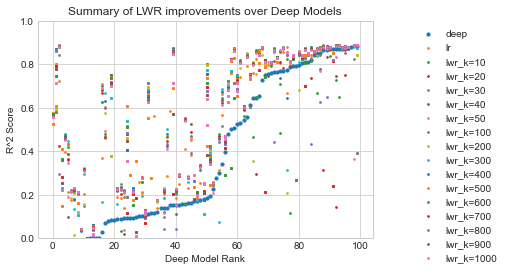

In [23]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

In [25]:
scores_df["n_features"] = [models[i].n_features for i in scores_df["model_num"]] 
from matplotlib.colors import Colormap
import seaborn as sns #heatmap of features - pls model - score
class nlcmap(Colormap):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)
    
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)


In [26]:
subset = scores_df[["predictor","n_features","R2"]]
subset = subset[np.logical_not(subset["predictor"]=="deep")]
subset = subset[np.logical_not(subset["predictor"]=="lr")]
trans = subset["predictor"].transform(lambda x: int(x.replace("lwr_k=",""))).tolist()
subset.loc[:,"predictor"]=trans
subset=subset.sort_values("predictor",ascending=False)

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

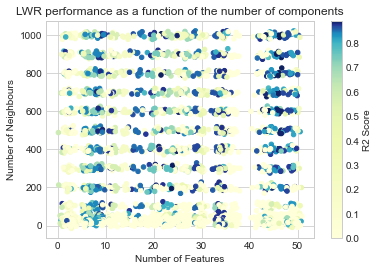

In [27]:
fig, ax = plt.subplots()
sc = ax.scatter(x=rand_jitter(subset["n_features"]), y=rand_jitter(subset["predictor"]), s=20,c=subset["R2"],cmap=cmap_nonlin,vmin=0)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Number of Neighbours")

cbar = fig.colorbar(sc,label="R2 Score")

ax.set_title("LWR performance as a function of the number of components")
plt.savefig(log_dir/f"heat_scatter.png", bbox_inches='tight')